# Forecasting Wildfires in Mendocino National Forest
<hr><br>

## Problem Statement
<hr><br>

With trends set in motion by Climate Change, wildfires are becoming an increasingly devastating force for populations around the world. In some regions, such as California in the United States, they are a leading cause of property loss, habitat destruction, and GHG emissions. In the 2020 fire season, wildfires in California caused over 12 Billion USD in damages. There is a high demand for prediction capabilities in regions such as this. Even small predictive ability on the order of minutes or hours could avert billions in damages by allowing first responders the ability to mitigate blazes before they spread, erect preventative measures, mobilize resources proactively to blaze sites, and begin evacuation efforts before residents are in peril. This project attempts to predict and forecast wildfires, using machine learning classifier algorithms, in Mendocino National Forest.

<br>

## Data Collection
<hr><br>

This project makes extensive use of Google Earth Engine. Before we begin, we must import **ee** and authenticate. 

In [1]:
import ee
import numpy as np
import pandas as pd
import os

ee.Authenticate()
ee.Initialize()

Enter verification code:  4/1AfJohXl5UfIDVcagmiz5inQCTQ9ANUWM8nxlFFV0twbGf8AsglAYtFKa97A



Successfully saved authorization token.


<br>

This analysis makes use of several datasets in order to extract disparate features that are important for determining if an area is at risk of wildfire. These include, but are not limited to, `elevation`, previous `fires`, `surface reflectance` and `emissivity`, `land surface temperature`, `dewpoint temperature`, `temperature`, `surface pressure`, `precipitation`, and `wind`. The datasets used in this analysis are as follows:

* [USGS_SRTMGL1_003](https://developers.google.com/earth-engine/datasets/catalog/USGS_SRTMGL1_003)
* [MODIS_061_MOD14A1](https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD14A1)
* [MODIS_061_MOD11A1](https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD11A1)
* [MODIS_061_MOD09GA](https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD09GA)
* [ECMWF_ERA5_LAND_DAILY_AGGR](https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_DAILY_AGGR)

In [2]:
# Import USGS_SRTMGL1_003
elv = ee.Image('USGS/SRTMGL1_003')

# Import MODIS_061_MOD14A1
ta = ee.ImageCollection('MODIS/061/MOD14A1').select('FireMask')

# Import MODIS_061_MOD11A1
lst = (ee.ImageCollection('MODIS/061/MOD11A1')
    .select(
        'LST_Day_1km',
        'LST_Night_1km',
        'Emis_31',
        'Emis_32'
    ))

# Import MODIS_061_MOD09GA
sr = (ee.ImageCollection('MODIS/061/MOD09GA')
    .select(
        'sur_refl_b01', 
        'sur_refl_b02', 
        'sur_refl_b03', 
        'sur_refl_b04', 
        'sur_refl_b05', 
        'sur_refl_b06', 
        'sur_refl_b07'
    ))

# Import ECMWF_ERA5_LAND_DAILY_AGGR
era = (ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR')
    .select(
        'dewpoint_temperature_2m_max',
        'temperature_2m_max',
        'u_component_of_wind_10m_max', 
        'v_component_of_wind_10m_max',
        'surface_pressure_max',
        'total_precipitation_sum',
    ))

In order to extract data from the various datasets, we must first define a `start` and `end` date, as well as a starting and stopping `longitude` and `latitude` and an associated `step` size. For this experiment, we decided to extract data from $2018$ to $2021$, starting at $39.10$ `latitude` and $-123.20$ `longitude` and stopping at $40.30$ `latitude` and $-122.60$ `longitude`. With a `step` size of $0.01$ - roughly equivalent to $1$ km at the equator - we extract roughly $4$ samples per given $1$ km<sup>2</sup> bounding box per day. In order to reduce the size of our dataset, we calculate the mean values for our samples in each of our bounding boxes per day. Of course, this could mean that a bounding box with an active fire is not detected as a result of this aggregation. 

In [1]:
startLat = 39.10
stopLat = 40.30
startLon = -123.20
stopLon = -122.60
startDate = '2018-01-01'
stopDate = '2022-01-01'
step = 0.01
scale = 1000
on = ['time', 'longitude', 'latitude']

def getData(output, startLat=startLat, stopLat=stopLat, startLon=startLon, stopLon=stopLon, startDate=startDate, stopDate=stopDate, step=step, scale=scale, on=on):    
    print('Started collecting data!')
    
    for lat in np.arange(startLat, stopLat, step):
        for lon in np.arange(startLon, stopLon, step):
            print('Collecting data for region %f, %f, %f, %f' % (lat, lat + step, lon, lon + step))
            roi = ee.Geometry.BBox(lon, lat, lon + step, lat + step)

            ta_region = ta.filterDate(startDate, stopDate).getRegion(roi, scale).getInfo()
            lst_region = lst.filterDate(startDate, stopDate).getRegion(roi, scale).getInfo()
            sr_region = sr.filterDate(startDate, stopDate).getRegion(roi, scale).getInfo()
            era_region = era.filterDate(startDate, stopDate).getRegion(roi, scale).getInfo()

            ta_df = pd.DataFrame(ta_region[1:], columns=ta_region[0]).drop(columns='id')
            lst_df = pd.DataFrame(lst_region[1:], columns=lst_region[0]).drop(columns='id')
            sr_df = pd.DataFrame(sr_region[1:], columns=sr_region[0]).drop(columns='id')
            era_df = pd.DataFrame(era_region[1:], columns=era_region[0]).drop(columns='id')

            merged = ta_df.merge(lst_df, on=on).merge(sr_df, on=on).merge(era_df, on=on)
            df = merged.groupby('time').mean().reset_index()
            elevation = elv.sample(roi, scale).aggregate_mean('elevation').getInfo()
            df['elevation'] = elevation
            df.to_csv(output, index=False, mode='a', header=not os.path.exists(output))
            
    print('Finished collecting data!')

# Uncomment next line to fetch data
# getData('../data/output.csv', startLat, stopLat, startLon, stopLon)

<br>

## 1. Import Libraries
<hr>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm.sklearn import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_validate, TimeSeriesSplit
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import eli5
import shap
pd.set_option('display.max_columns', None)

<br>

## 2. Problem Discussion
<hr><br>

In [2]:
df = pd.read_csv('../data/working.csv')
df = df.rename(columns={
    'FireMask':'fire_today', 
    'LST_Day_1km':'lst_day',
    'LST_Night_1km':'lst_night', 
    'Emis_31':'emis_31', 
    'Emis_32':'emis_32',
    'dewpoint_temperature_2m_max':'dewpoint_temperature',
    'temperature_2m_max':'temperature',
    'u_component_of_wind_10m_max':'u_wind', 
    'v_component_of_wind_10m_max':'v_wind',
    'surface_pressure_max':'surface_pressure',
    'total_precipitation_sum':'precipitation',
})
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10687200 entries, 0 to 10687199
Data columns (total 22 columns):
 #   Column                Non-Null Count     Dtype  
---  ------                --------------     -----  
 0   time                  10687200 non-null  int64  
 1   longitude             10687200 non-null  float64
 2   latitude              10687200 non-null  float64
 3   fire_today            10687200 non-null  float64
 4   lst_day               7136496 non-null   float64
 5   lst_night             6782409 non-null   float64
 6   emis_31               8302446 non-null   float64
 7   emis_32               8302446 non-null   float64
 8   sur_refl_b01          10643280 non-null  float64
 9   sur_refl_b02          10642687 non-null  float64
 10  sur_refl_b03          10643279 non-null  float64
 11  sur_refl_b04          10643279 non-null  float64
 12  sur_refl_b05          10643269 non-null  float64
 13  sur_refl_b06          10643279 non-null  float64
 14  sur_refl_b07    

<br>

As we can see above, after joining the three datasets, we're left with a dataframe with $22$ features. This dataset contains $10,687,200$ entries or examples and occupies ~$1.8$ GB of memory. Regarding the features, we will use the `fire_today` field to calculate our target variable: `fire_tomorrow`. Note that the `fire_today` field takes on the following values:

1. Not processed (obsolete; not used since Collection 1)
2. Not processed (other reason)
3. Non-fire water pixel
4. Cloud (land or water)
5. Non-fire land pixel
6. Unknown (land or water)
7. Fire (low confidence, land or water)
8. Fire (nominal confidence, land or water)
9. Fire (high confidence, land or water)

Ideally, we'd like to convert this problem into a binary classification problem: $0$ means no fire and $1$ means fire. Although the `fire_today` field provides confidence levels, we'll consider all three fire values ($7$, $8$, and $9$) as fire. The rationale here is that if our model predicts a false positive then it would be predicting in an overly cautious manner. In the case of wildfires, we believe this is an acceptable course of action. The following line of code does exactly this: transforms the `fire_today` field to indicate a $0$ (no fire) for all values less than $7$ and a $1$ (fire) for all values greater to or equal than $7$.

In [3]:
df['fire_today'] = np.where(df['fire_today'] >= 7, 1, 0)

<br>

## 3. Exploratory Data Analysis
<hr><br>

The first form of feature engineering we'll perform is extracting the `month` and `year` from the `date` field. From here, we can use one-hot encoding on our new features to give our model more useful information to extract and learn from. We will also combine the `latitude` and `longitude` fields into a single field called `region`. Lastly, because most wildfires in Mendocino National Forest occur in the summer months, we will focus on `August` and `September`.

In [4]:
df['date'] = pd.to_datetime(df['time'], unit='ms')
df = df[(df['date'].dt.month >= 7) & (df['date'].dt.month <= 10)]
df['month'] = df['date'].dt.month_name()
df['year'] = df['date'].dt.year
df[['x', 'y']] = OrdinalEncoder().fit_transform(df[['longitude', 'latitude']])

groups = df.groupby('date')
for name, group in groups:
    if group['fire_today'].sum() == 0:
        df = df.drop(group.index)

df

,time,longitude,latitude,fire_today,lst_day,lst_night,emis_31,emis_32,sur_refl_b01,sur_refl_b02,sur_refl_b03,sur_refl_b04,sur_refl_b05,sur_refl_b06,sur_refl_b07,dewpoint_temperature,temperature,u_wind,v_wind,surface_pressure,precipitation,elevation,date,month,year,x,y
208,1532736000000,-123.194958,39.108156,0,15628.0,14711.0,245.5,247.0,669.0,2512.5,356.0,608.5,2421.5,1734.0,983.5,285.476746,307.758743,3.046509,0.193535,95564.093750,8.457610e-07,190.0,2018-07-28,July,2018,0.0,0.0
209,1532822400000,-123.194958,39.108156,0,15745.5,14639.0,246.0,247.5,1127.5,3582.0,568.0,991.0,3861.5,2985.0,1783.5,285.721069,306.486847,2.802200,-0.059257,95703.417969,1.018643e-05,190.0,2018-07-29,July,2018,0.0,0.0
210,1532908800000,-123.194958,39.108156,0,15719.5,14632.0,245.5,247.0,684.5,2484.0,355.5,608.0,2423.0,1803.0,998.5,284.861404,306.058380,2.819260,-0.758291,95697.886719,1.034141e-05,190.0,2018-07-30,July,2018,0.0,0.0
211,1532995200000,-123.194958,39.108156,0,15622.0,14567.0,246.0,247.5,1024.0,3532.0,529.5,931.0,3630.5,2731.5,1541.5,285.624969,306.540482,2.865234,-0.704128,95693.539062,7.229447e-05,190.0,2018-07-31,July,2018,0.0,0.0
212,1533081600000,-123.194958,39.108156,0,NaN,14626.5,246.0,248.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,285.491547,305.029526,3.014359,-0.981888,95629.734375,4.240870e-06,190.0,2018-08-01,August,2018,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10687067,1629417600000,-122.597578,40.293932,0,15832.0,14818.0,246.0,248.0,1258.0,2311.0,576.0,935.0,3092.0,3203.0,2041.0,287.095306,309.058838,1.427582,1.374362,98009.582031,1.722574e-06,291.0,2021-08-20,August,2021,60.0,119.0
10687068,1629504000000,-122.597578,40.293932,0,15400.0,14724.0,247.0,249.0,663.0,1765.0,71.0,298.0,2395.0,2417.0,1286.0,286.710602,308.663116,-0.061111,2.098974,97698.226562,8.523463e-07,291.0,2021-08-21,August,2021,60.0,119.0
10687069,1629590400000,-122.597578,40.293932,0,15683.0,14561.0,246.0,248.0,1258.0,2482.0,557.0,940.0,3330.0,3362.0,2089.0,286.964508,305.934814,0.938324,2.829931,97900.667969,4.261732e-07,291.0,2021-08-22,August,2021,60.0,119.0
10687121,1634169600000,-122.597578,40.293932,0,15334.0,14224.0,246.0,248.0,1121.0,2053.0,480.0,821.0,2795.0,2819.0,1748.0,276.588058,296.662262,1.922577,0.111504,99166.496094,1.724345e-06,291.0,2021-10-14,October,2021,60.0,119.0


<br>

In [5]:
df.info(verbose=True, show_counts=True)
df.describe(include='all', datetime_is_numeric=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 980880 entries, 208 to 10687135
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   time                  980880 non-null  int64         
 1   longitude             980880 non-null  float64       
 2   latitude              980880 non-null  float64       
 3   fire_today            980880 non-null  int64         
 4   lst_day               873038 non-null  float64       
 5   lst_night             879937 non-null  float64       
 6   emis_31               953181 non-null  float64       
 7   emis_32               953181 non-null  float64       
 8   sur_refl_b01          973560 non-null  float64       
 9   sur_refl_b02          973452 non-null  float64       
 10  sur_refl_b03          973560 non-null  float64       
 11  sur_refl_b04          973560 non-null  float64       
 12  sur_refl_b05          973560 non-null  float64       


,time,longitude,latitude,fire_today,lst_day,lst_night,emis_31,emis_32,sur_refl_b01,sur_refl_b02,sur_refl_b03,sur_refl_b04,sur_refl_b05,sur_refl_b06,sur_refl_b07,dewpoint_temperature,temperature,u_wind,v_wind,surface_pressure,precipitation,elevation,date,month,year,x,y
count,9.808800e+05,980880.000000,980880.000000,980880.000000,873038.000000,879937.000000,953181.000000,953181.000000,973560.000000,973452.000000,973560.000000,973560.000000,973560.000000,973560.000000,973516.000000,980880.000000,980880.000000,980880.000000,980880.000000,980880.000000,9.808800e+05,980880.000000,980880,980880,980880.000000,980880.000000,980880.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,August,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,468480,NaN,NaN,NaN
mean,1.579148e+12,-122.894980,39.699959,0.014689,15244.131180,14530.013536,247.413172,248.687220,1008.367457,2140.510461,751.552226,971.739872,2266.781870,1746.406959,1034.486456,282.053115,304.254848,1.677438,0.853382,90972.917350,4.158907e-05,1040.618238,2020-01-16 04:17:54.626865920,NaN,2019.373134,30.000000,59.500000
min,1.532736e+12,-123.194958,39.108156,0.000000,13997.000000,13543.000000,240.000000,241.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,24.000000,-62.000000,264.436798,288.939606,-1.542877,-2.455206,84141.574219,0.000000e+00,172.000000,2018-07-28 00:00:00,NaN,2018.000000,0.000000,0.000000
25%,1.535587e+12,-123.046736,39.402354,0.000000,15034.000000,14410.500000,247.000000,248.000000,419.000000,1613.500000,226.000000,414.000000,1737.000000,1269.000000,618.000000,279.501694,301.741409,1.054916,0.362991,88422.421875,0.000000e+00,674.000000,2018-08-30 00:00:00,NaN,2018.000000,15.000000,29.750000
50%,1.598357e+12,-122.894022,39.696552,0.000000,15223.000000,14543.000000,248.000000,249.000000,650.000000,2008.000000,358.000000,586.000000,2180.375000,1657.000000,952.000000,282.529831,304.589066,1.658020,0.908735,90755.472656,8.523464e-07,1017.000000,2020-08-25 12:00:00,NaN,2020.000000,30.000000,59.500000
75%,1.601251e+12,-122.741309,39.999734,0.000000,15443.000000,14663.000000,248.000000,249.000000,1050.000000,2474.000000,629.500000,949.000000,2646.000000,2105.000000,1349.000000,285.082474,307.089798,2.331360,1.400742,93750.878906,2.151728e-06,1389.000000,2020-09-28 00:00:00,NaN,2020.000000,45.000000,89.250000
max,1.635379e+12,-122.597578,40.293932,1.000000,17251.000000,16981.000000,252.000000,250.000000,13060.000000,10928.000000,12275.000000,12565.000000,9970.000000,10255.000000,11846.000000,292.275833,317.632523,4.152939,3.387817,99561.457031,3.080065e-03,2283.000000,2021-10-28 00:00:00,NaN,2021.000000,60.000000,119.000000


Examining the above tables, we see that there are $980,880$ entries or examples in our dataset. With the exception of the `date`, `month`, and `region` features, all of our columns are numeric: `int64` or `float64`. Recall that we've transformed `fire_today` into a binary feature, where $0$ means no fire and $1$ means fire. All of the numeric features use a variety of scales and will need to be scaled appropriately before training our model. Furthermore, the following features contain missing values which will need to be imputed: `lst_day`, `lst_night`, `emis_31`, `emis_32`, `sur_refl_b01`, `sur_refl_b02`, `sur_refl_b03`, `sur_refl_b04`, `sur_refl_b05`, `sur_refl_b06`, and `sur_refl_b07`.

<br>

In [6]:
df['fire_today'].value_counts(normalize=True)

0    0.985311
1    0.014689
Name: fire_today, dtype: float64

As we can see, we have fairly extreme class imbalance in our dataset. Only $1.5$% of our examples indicate that a fire has occurred! Therefore, we may need to use techniques like undersampling or oversampling, such as `SMOTE`, to achieve optimal results. To conclude, because of this extreme class imbalance, we will be evaluating our models using metrics which are more indicative of good performance in these situations. Namely, we will use the `roc_auc` evaluation metric. This metric, unlike `f1`, `recall`, or `precision`, evaluates models based on the probability of a target class being picked.

<br>

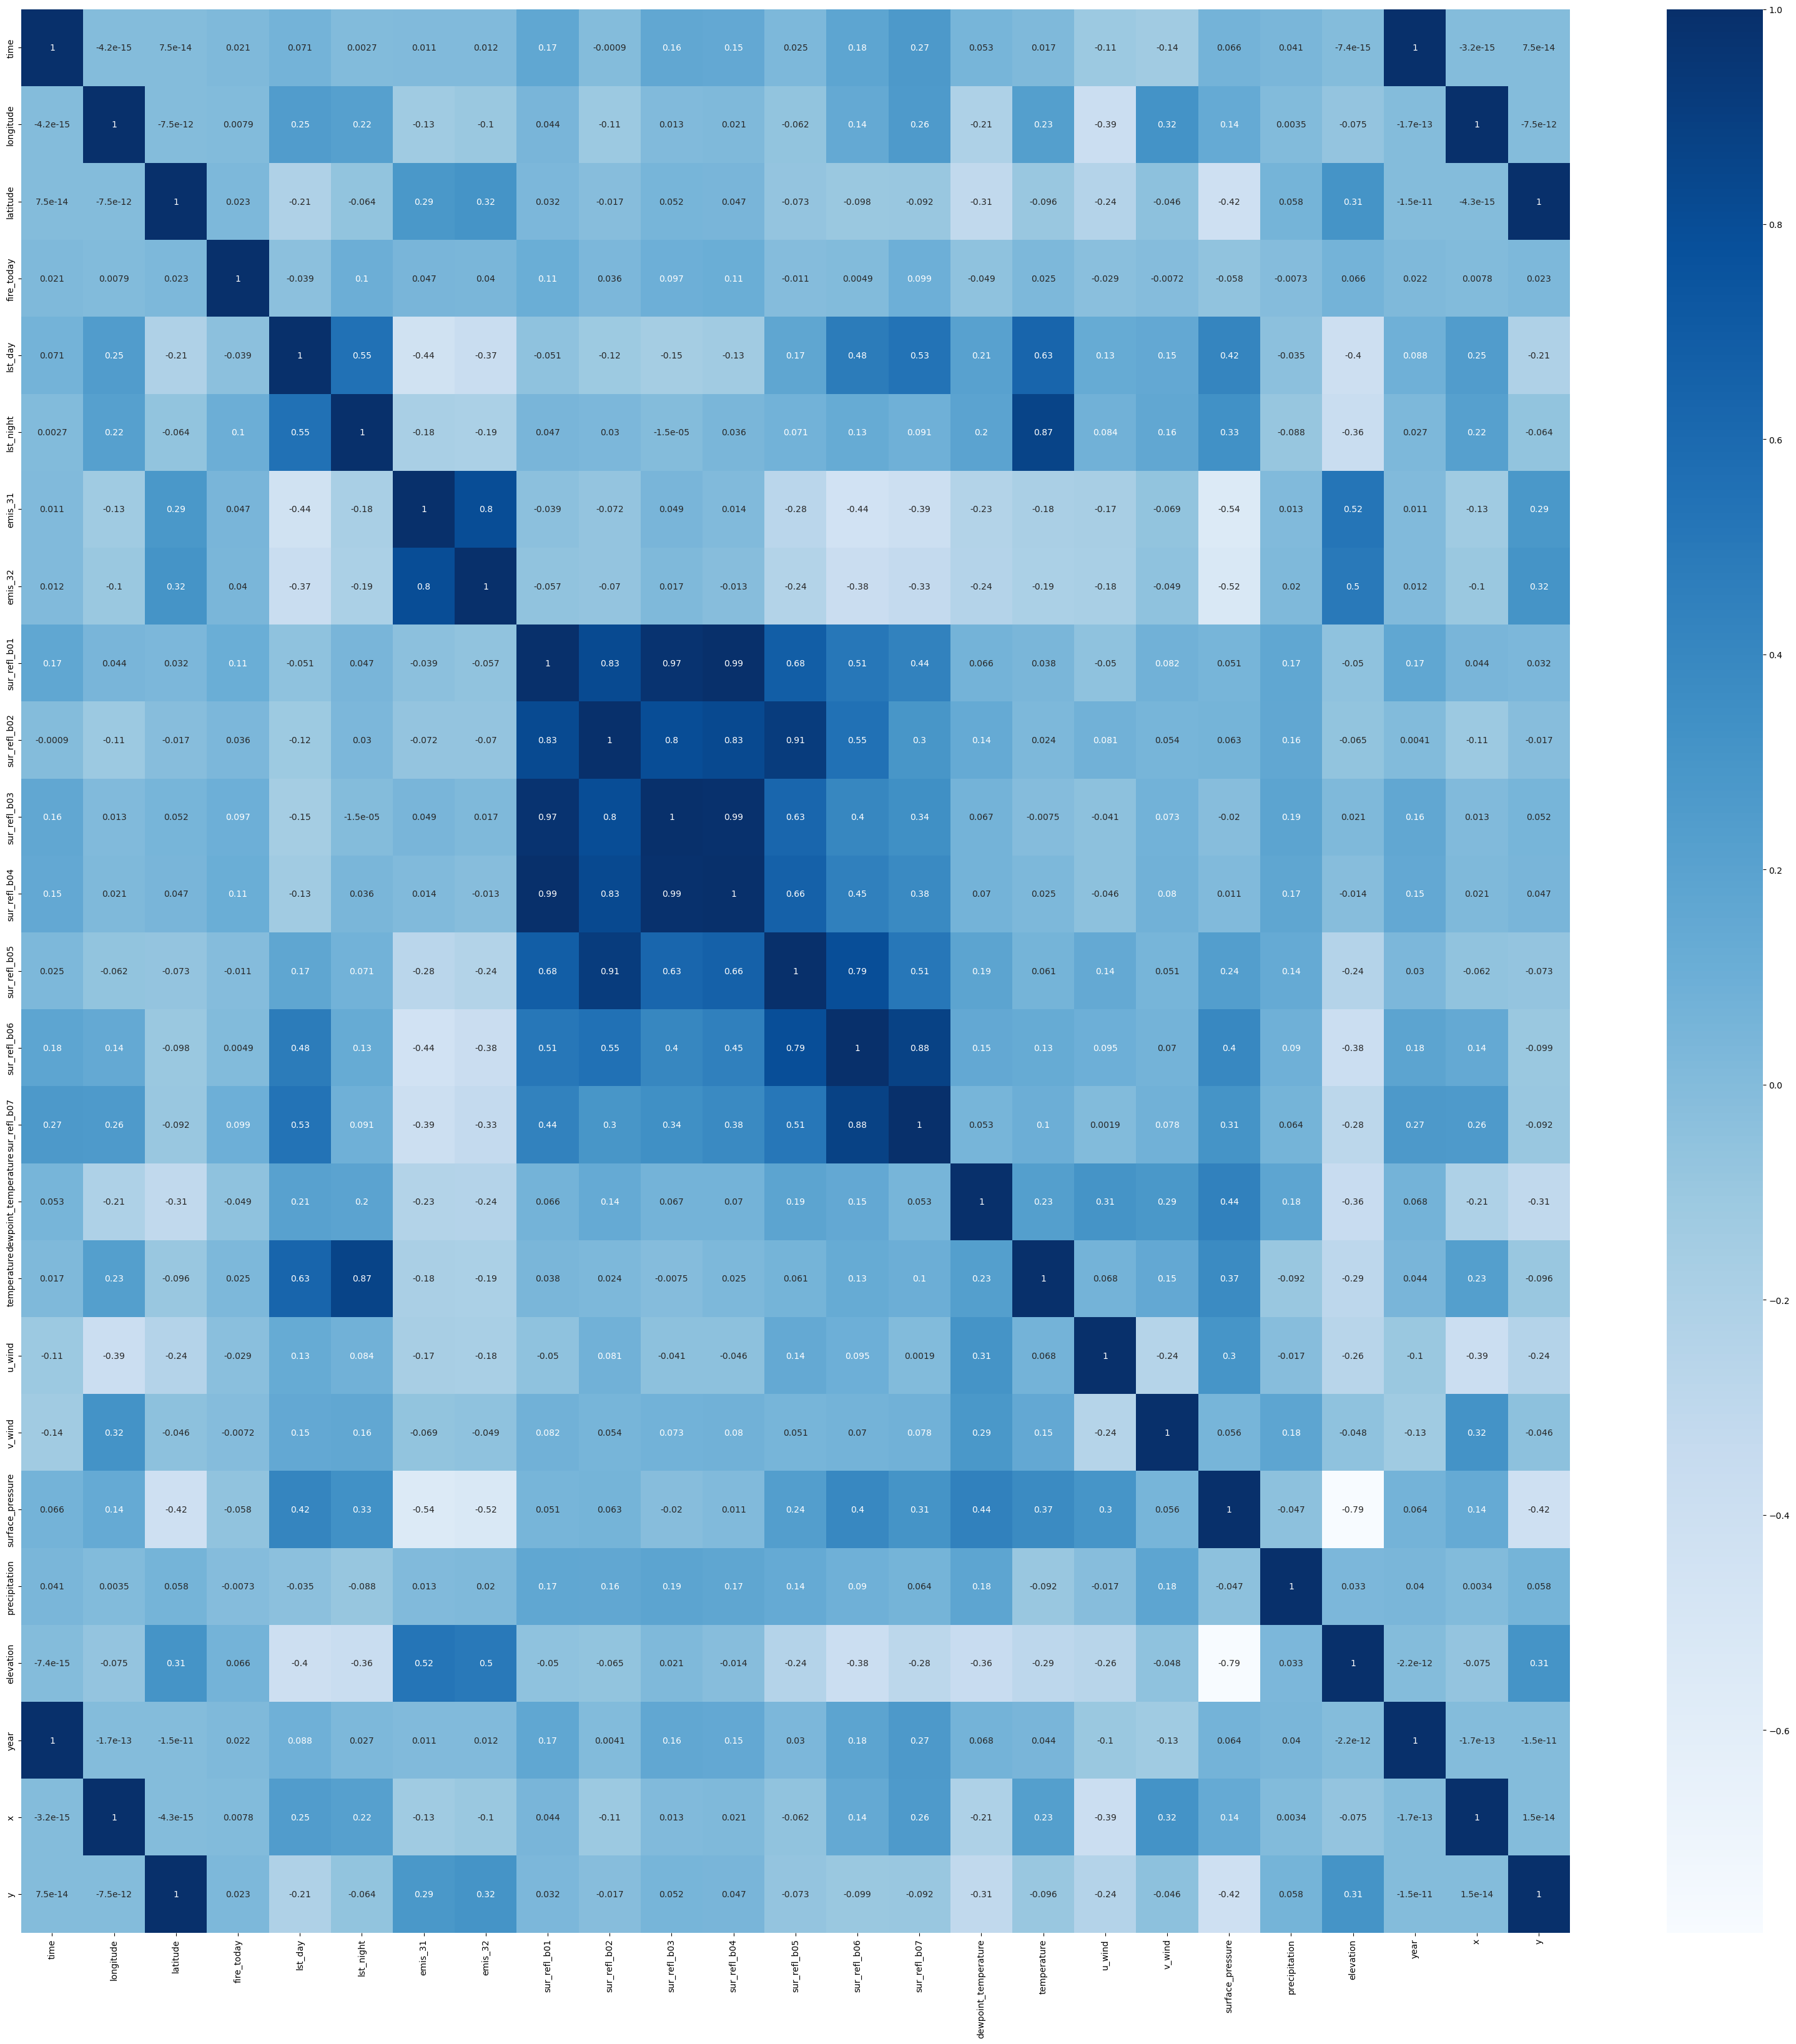

In [7]:
plt.figure(figsize=(40, 40))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap=plt.cm.Blues)
plt.show()

The above heatmap displays how correlated the various features are with one another. Features coming from the same MODIS datasets show high correlation with one another: `Land Surface Temperature`, `Emissivity`, and `Surface Reflection`. Examining the heatmap, we see the following:

* `lst_day` is correlated with `temperature` ($0.61$), `sur_refl_b06` ($0.49$) and `sur_refl_b07` ($0.56$)
* `lst_night` is correlated with `temperature` ($0.84$)
* `elevation` is correlated with `emis_31` ($0.52$) and `emis_32` ($0.5$)

<br>

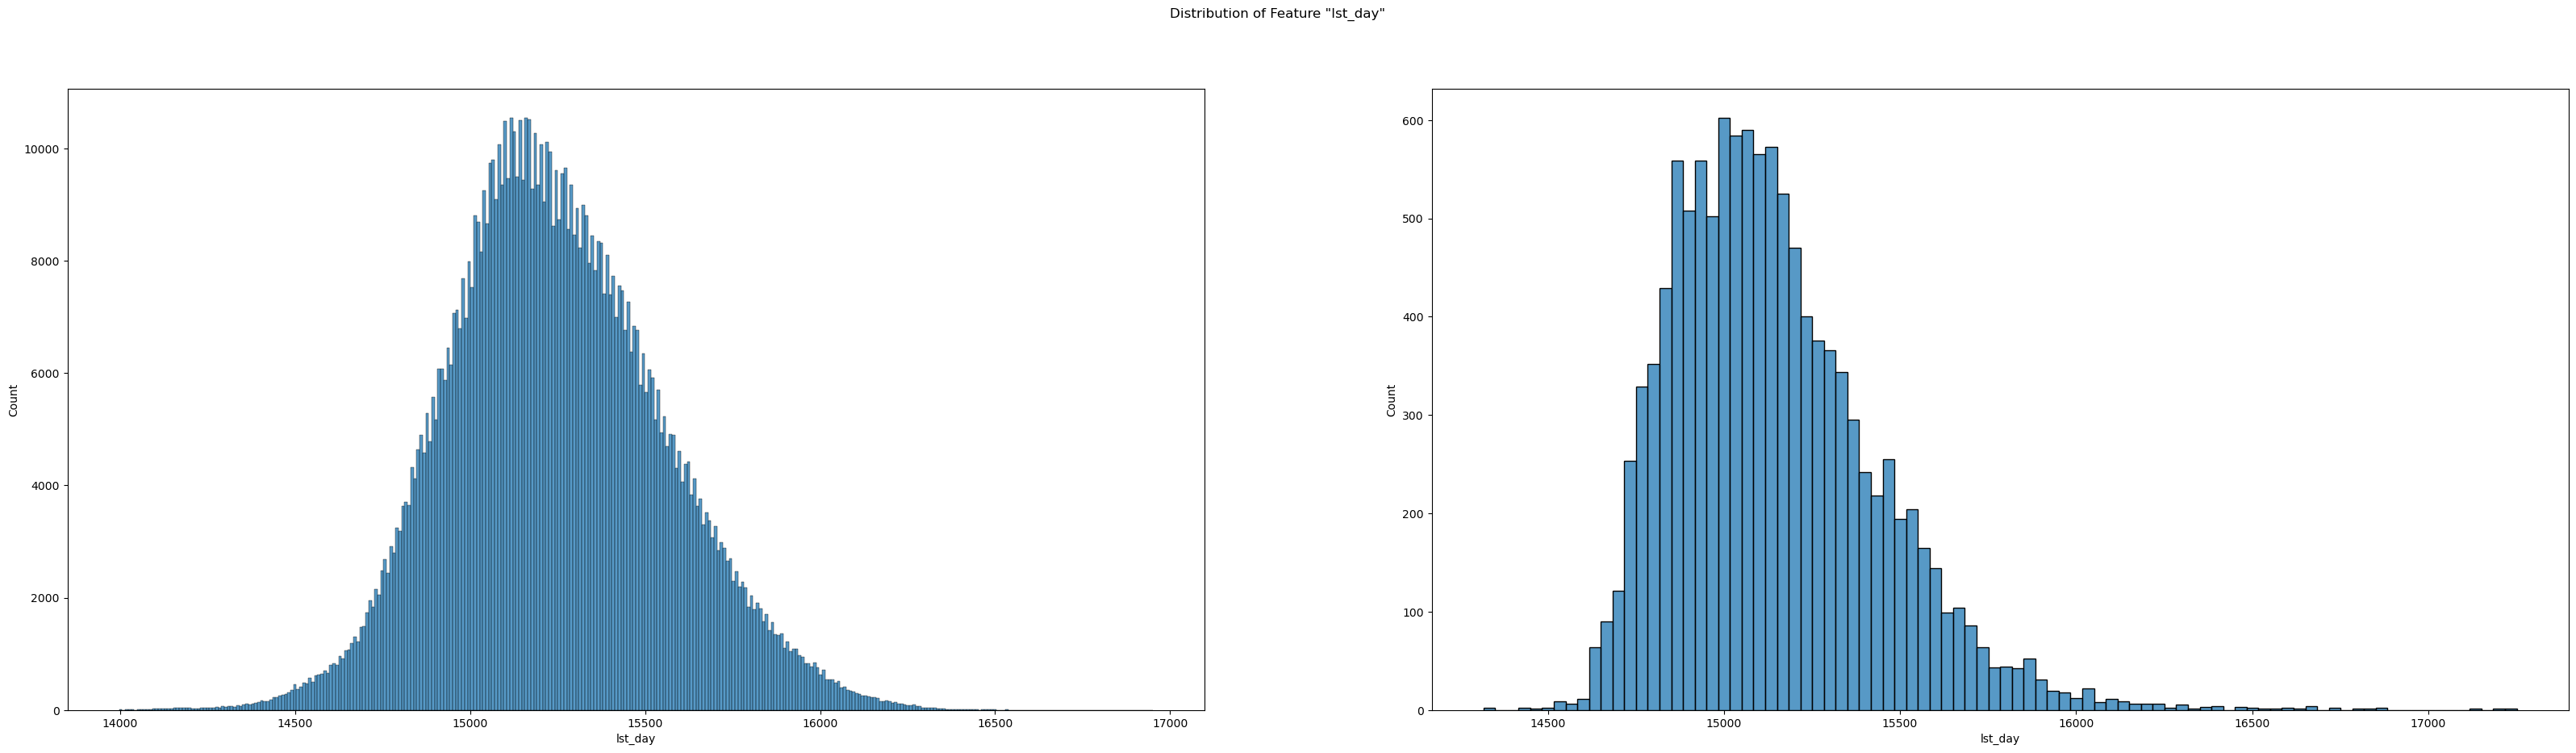

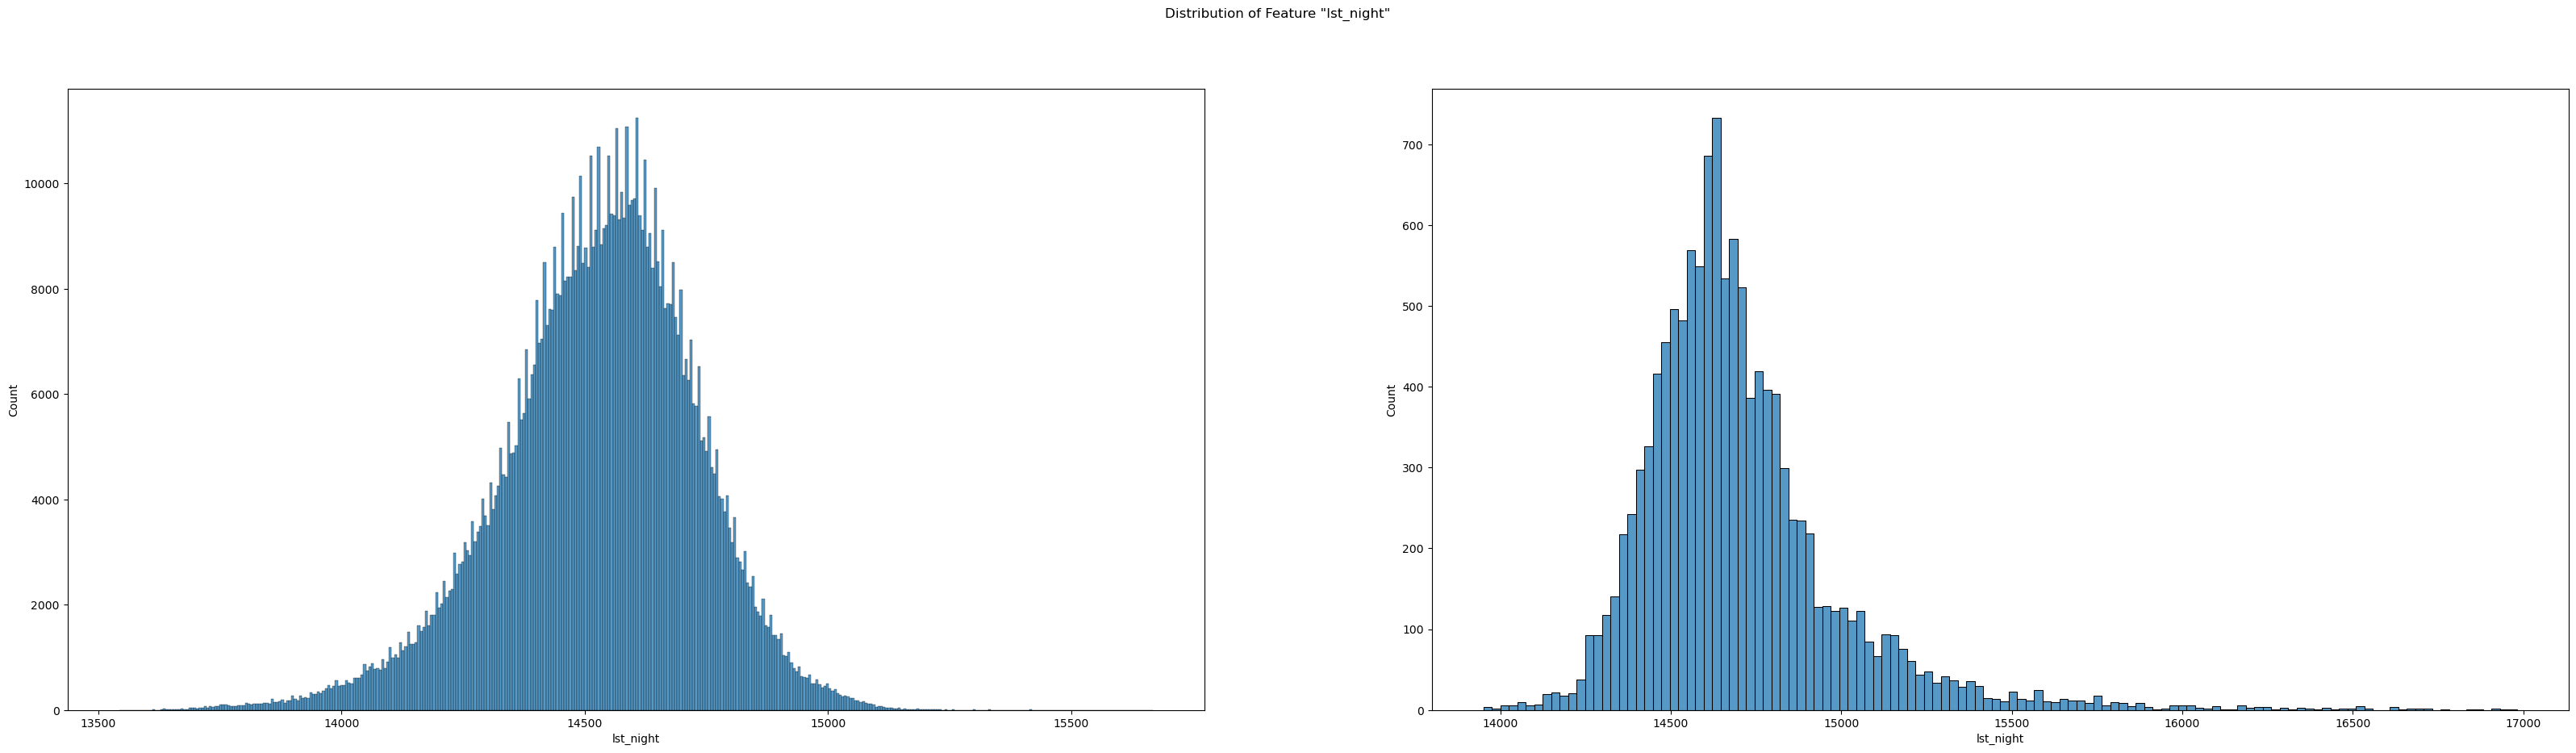

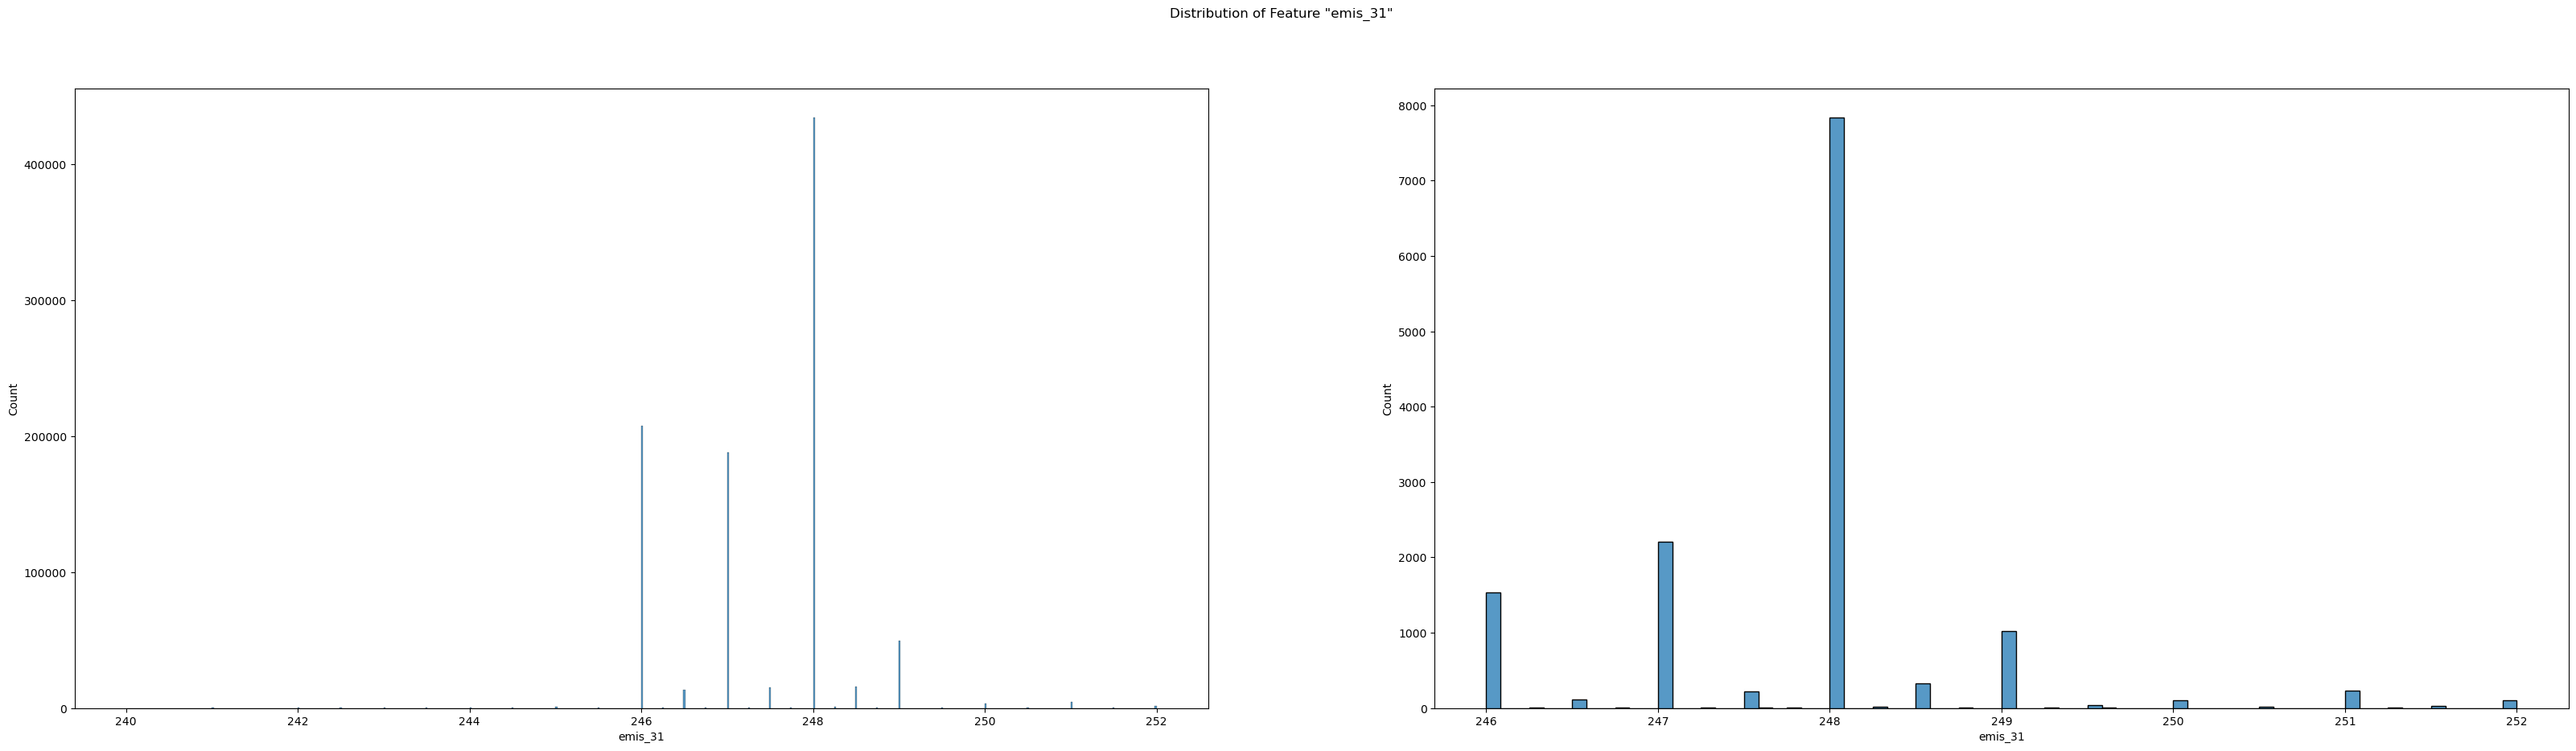

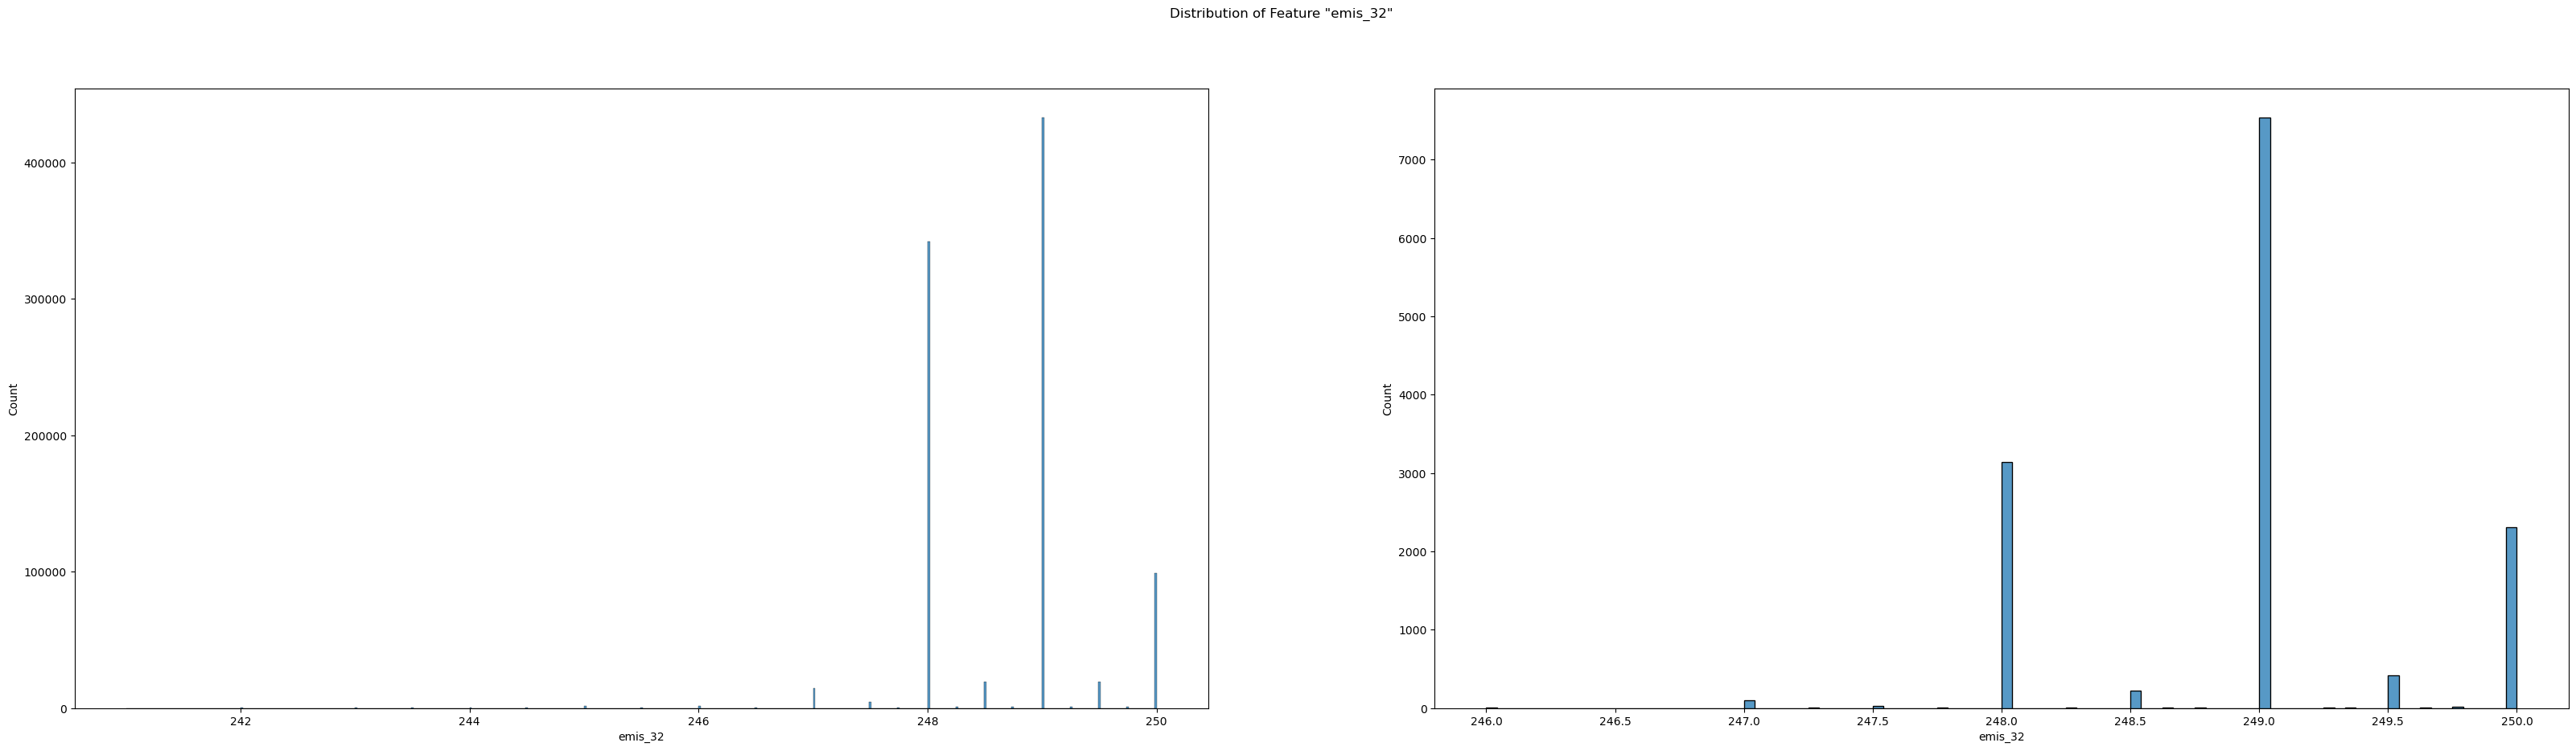

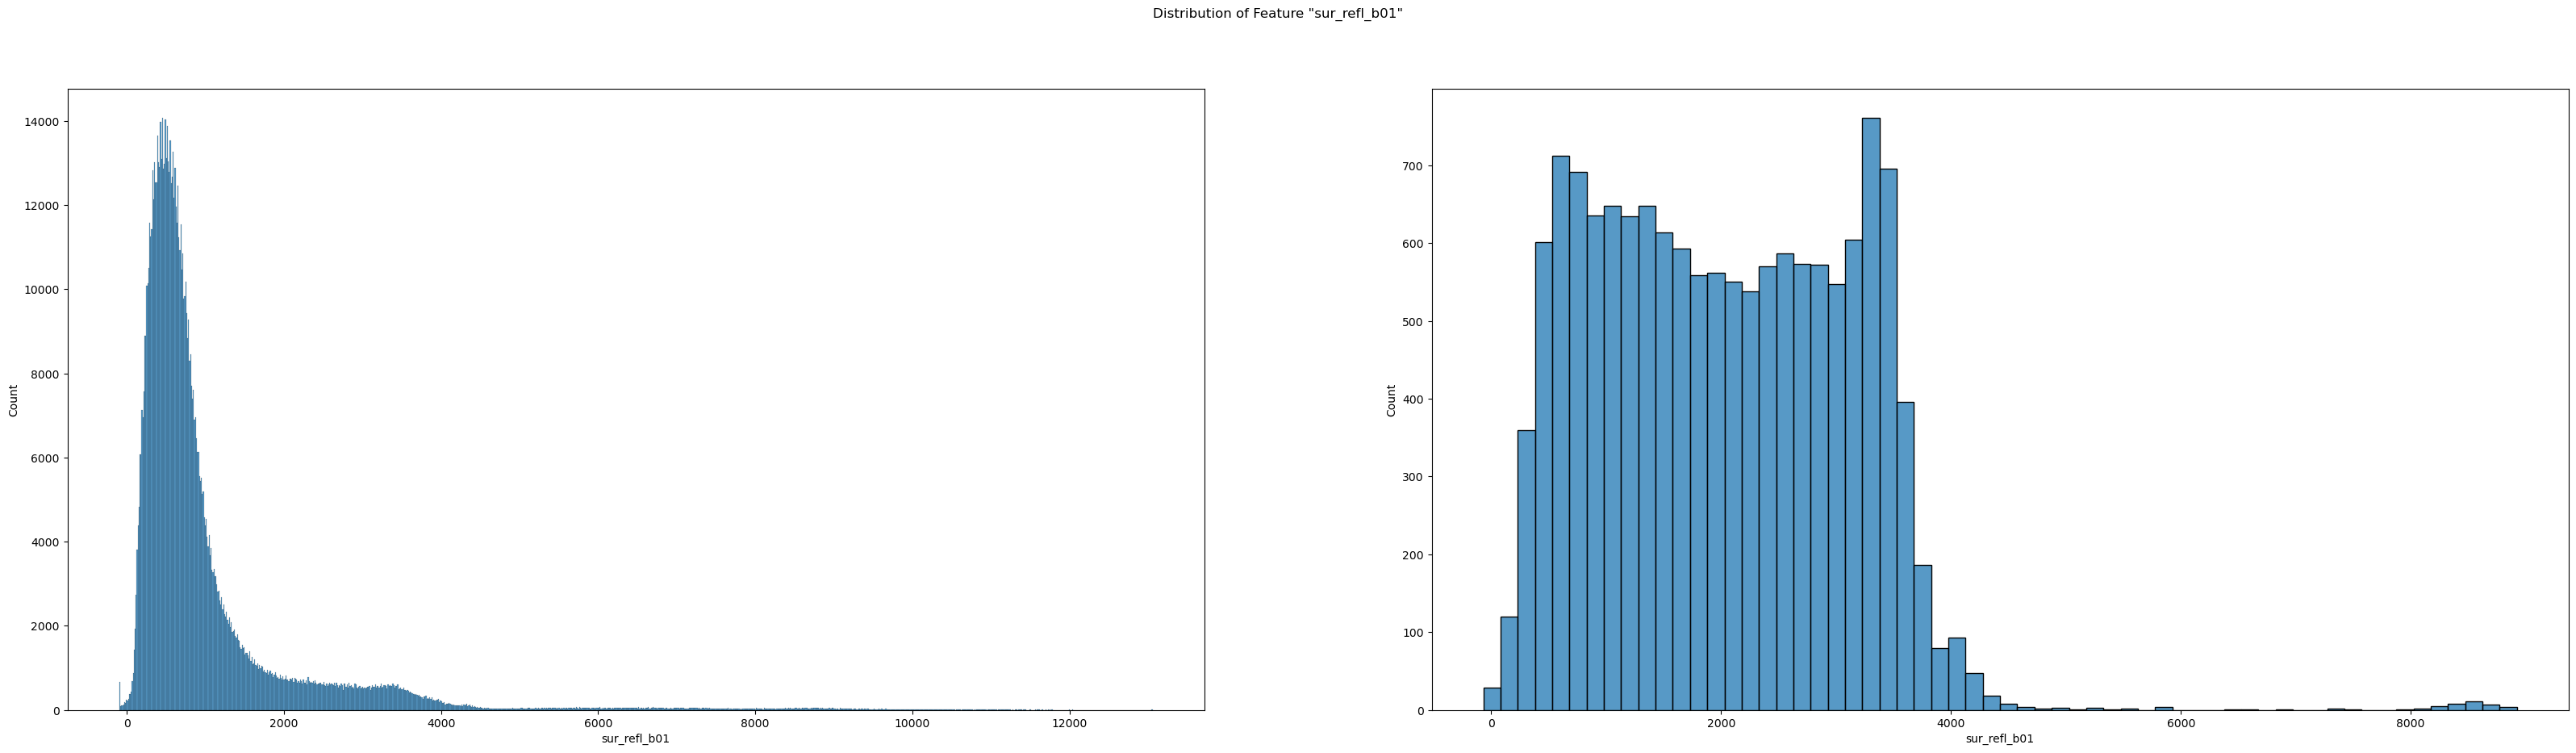

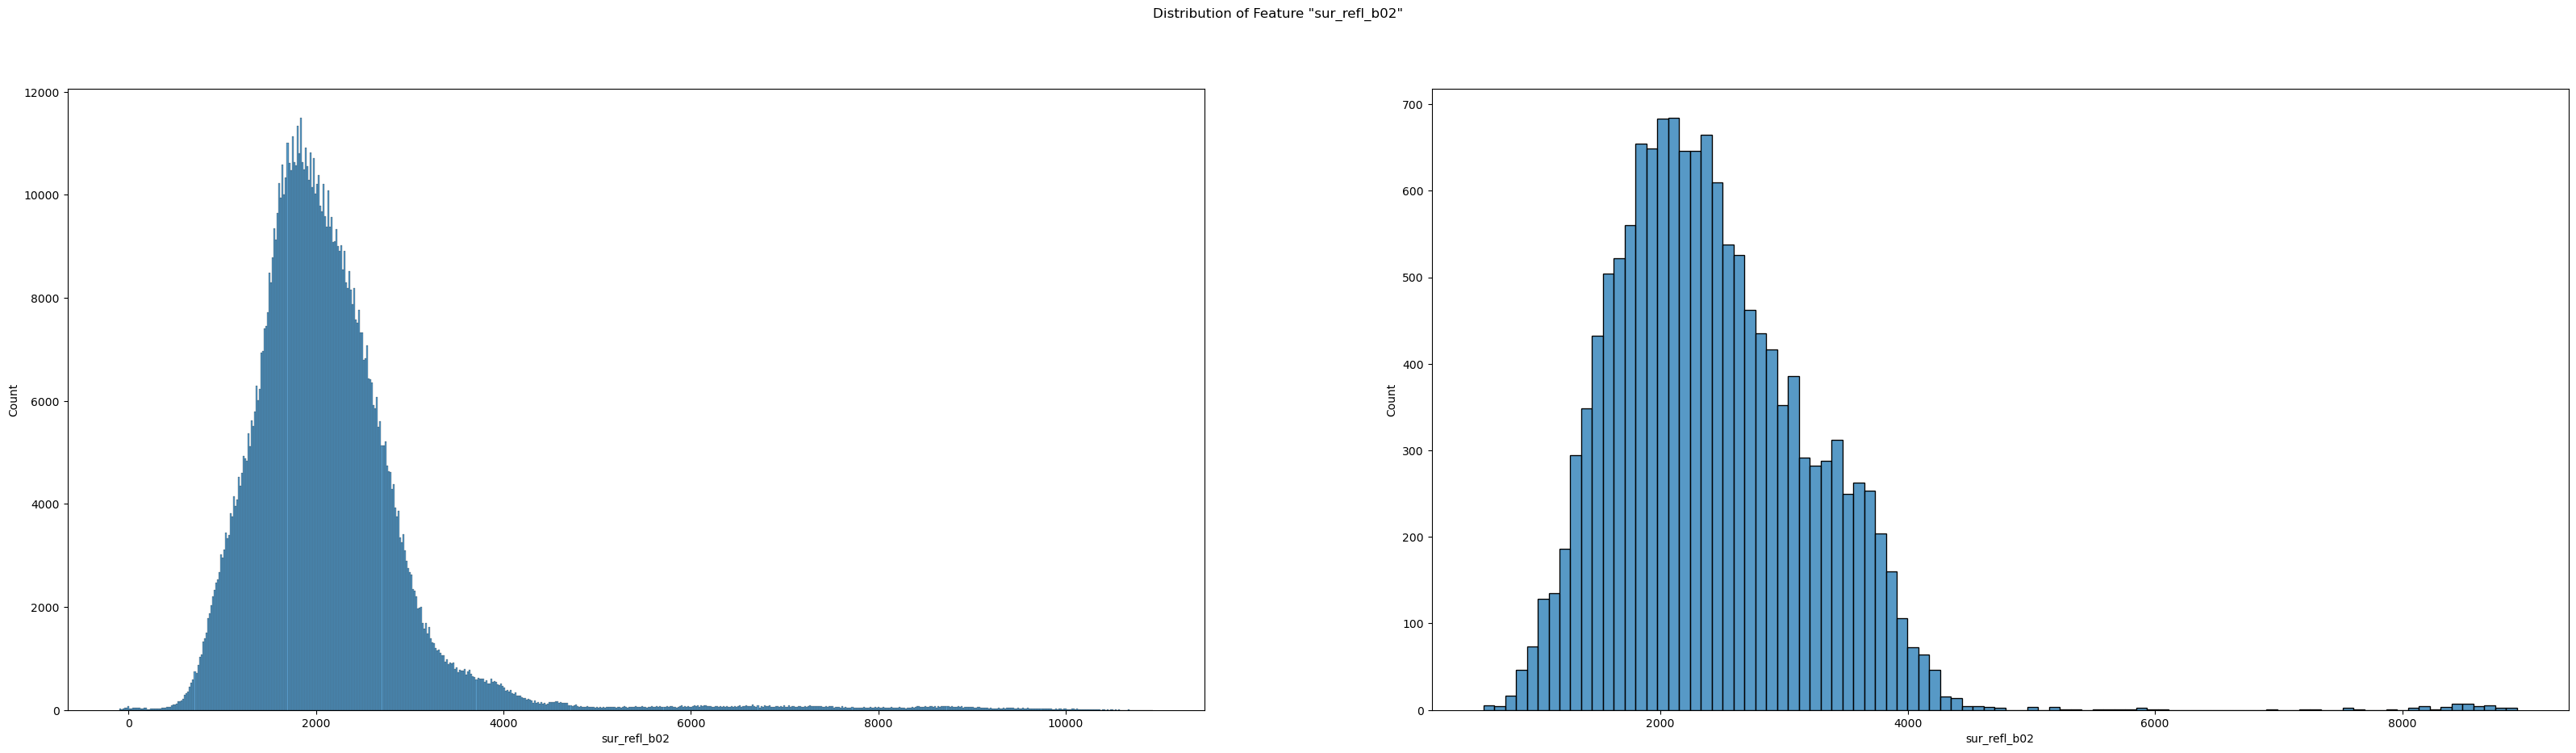

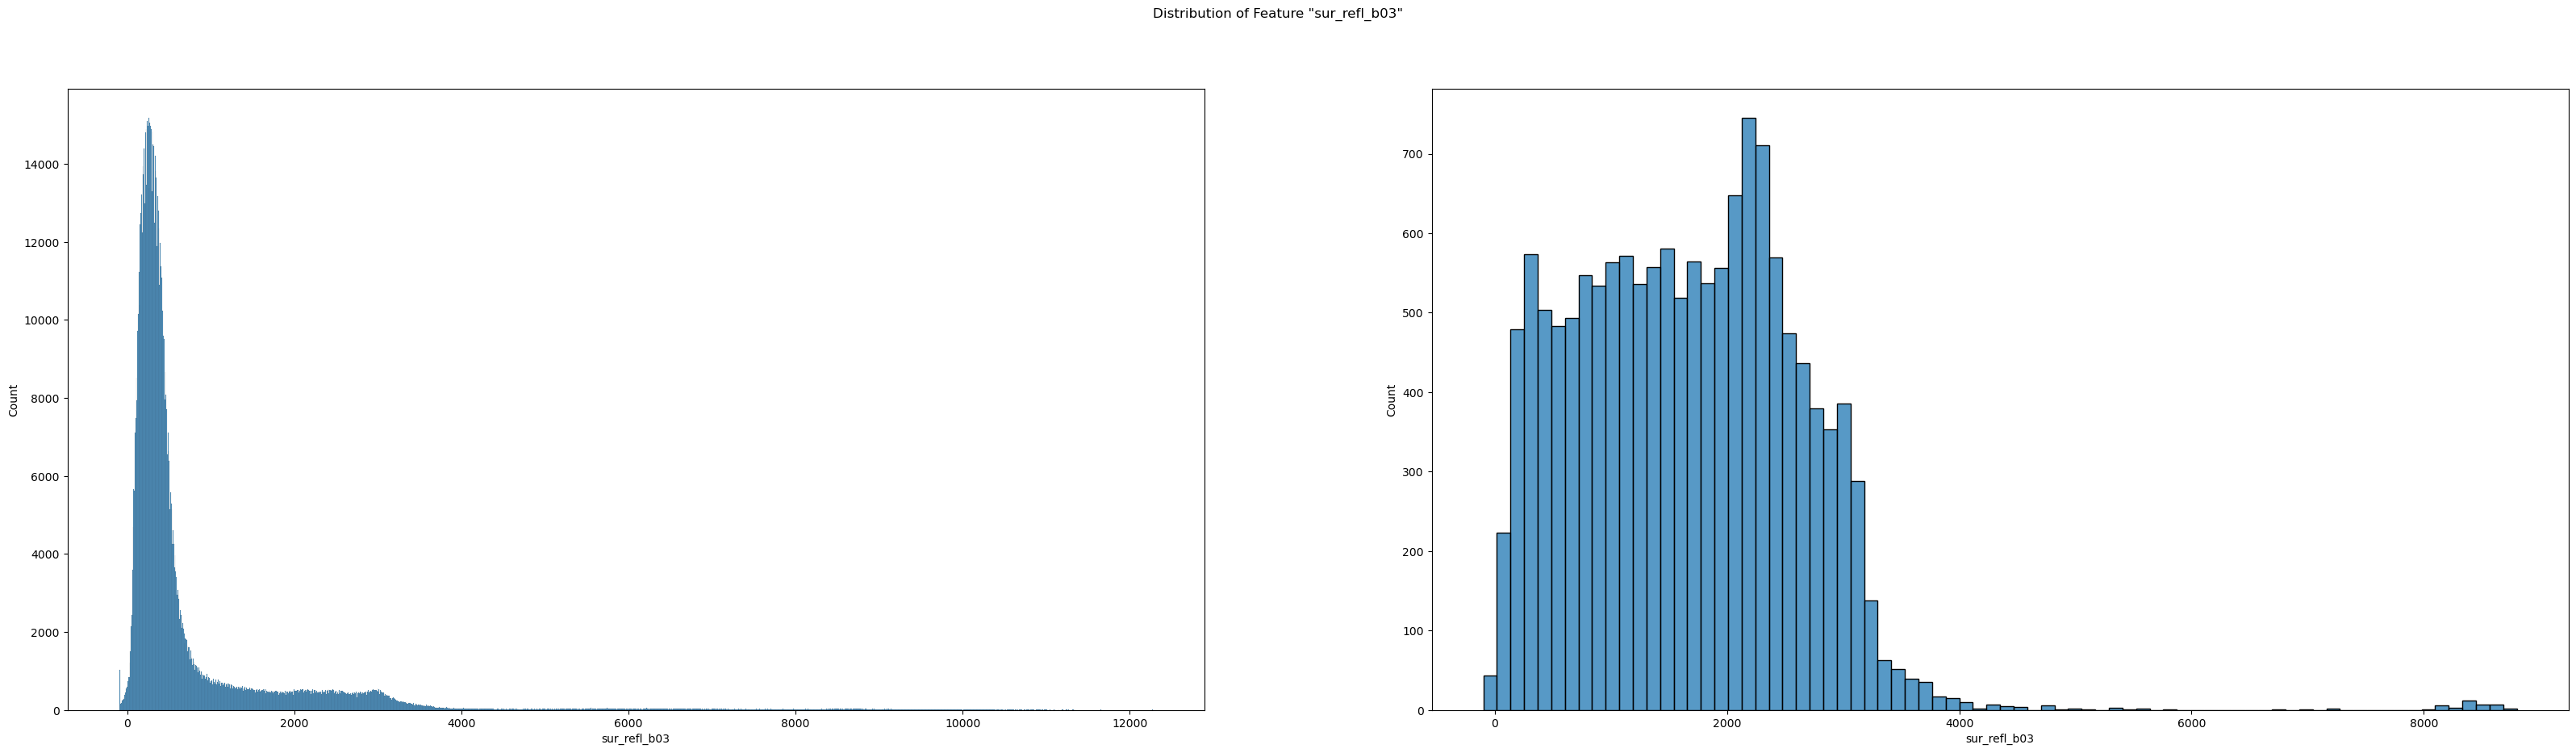

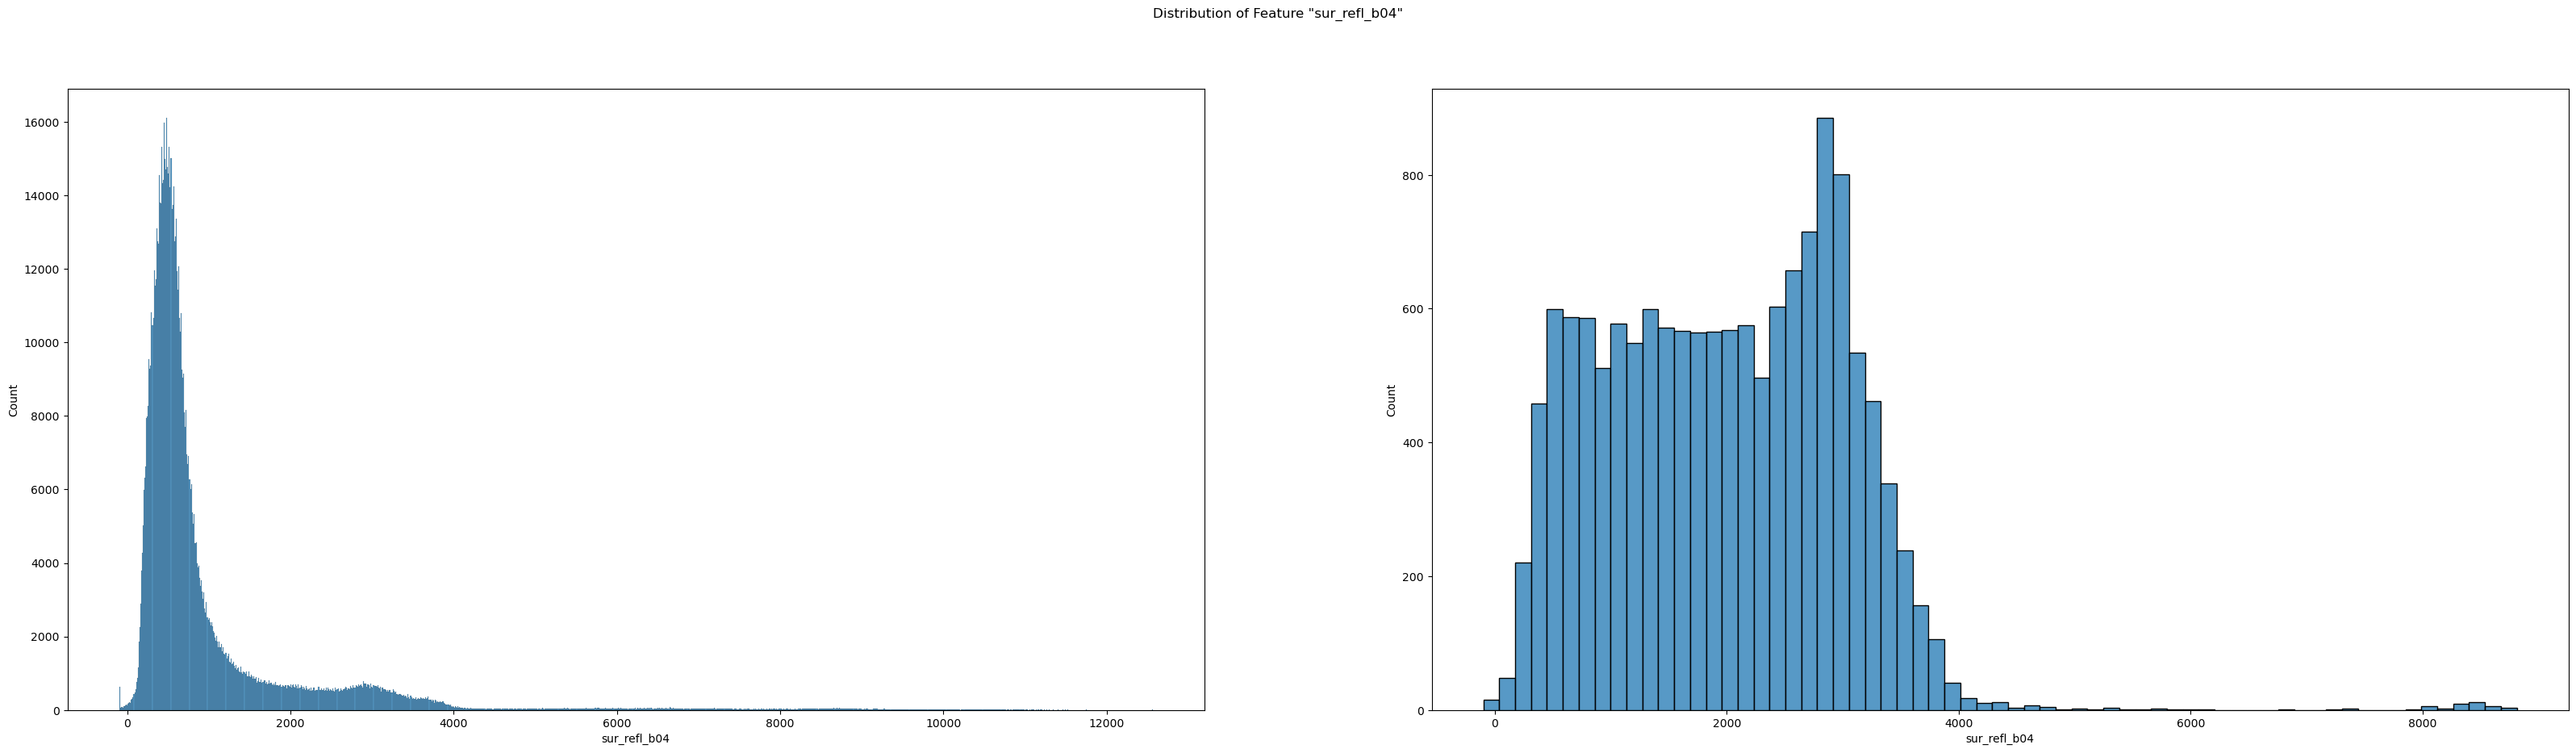

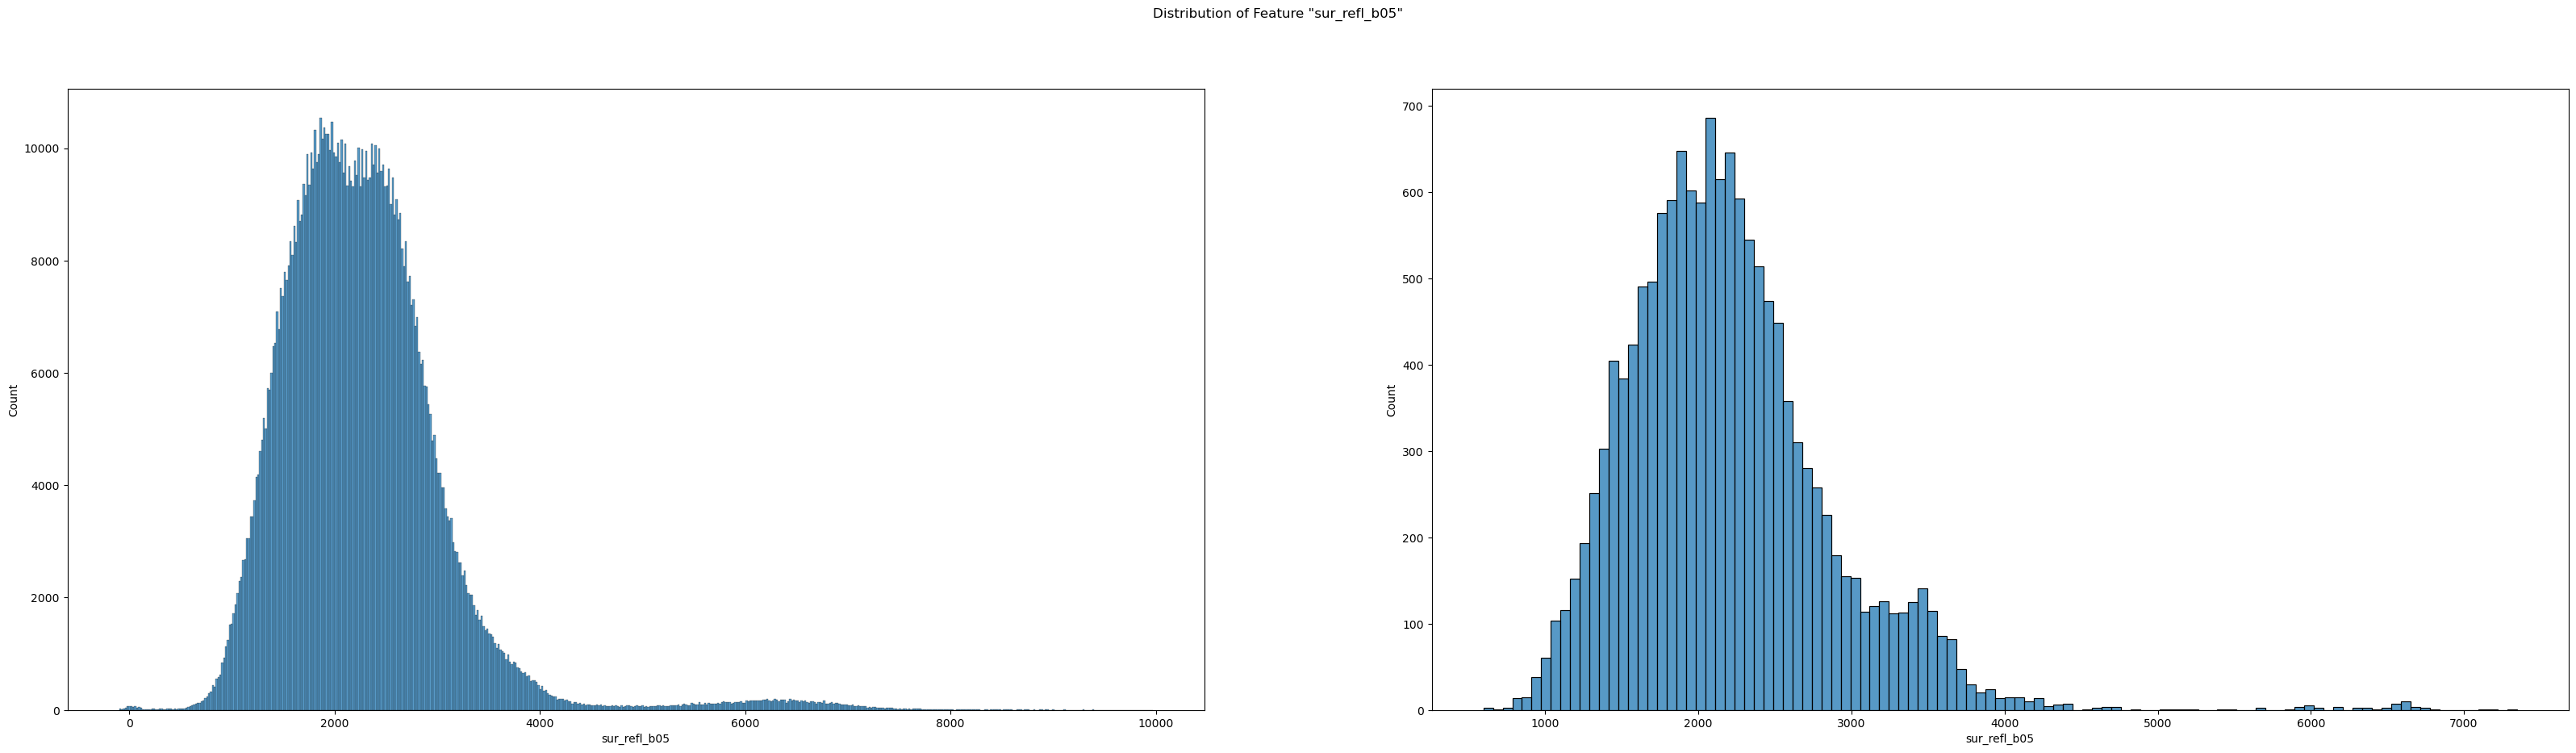

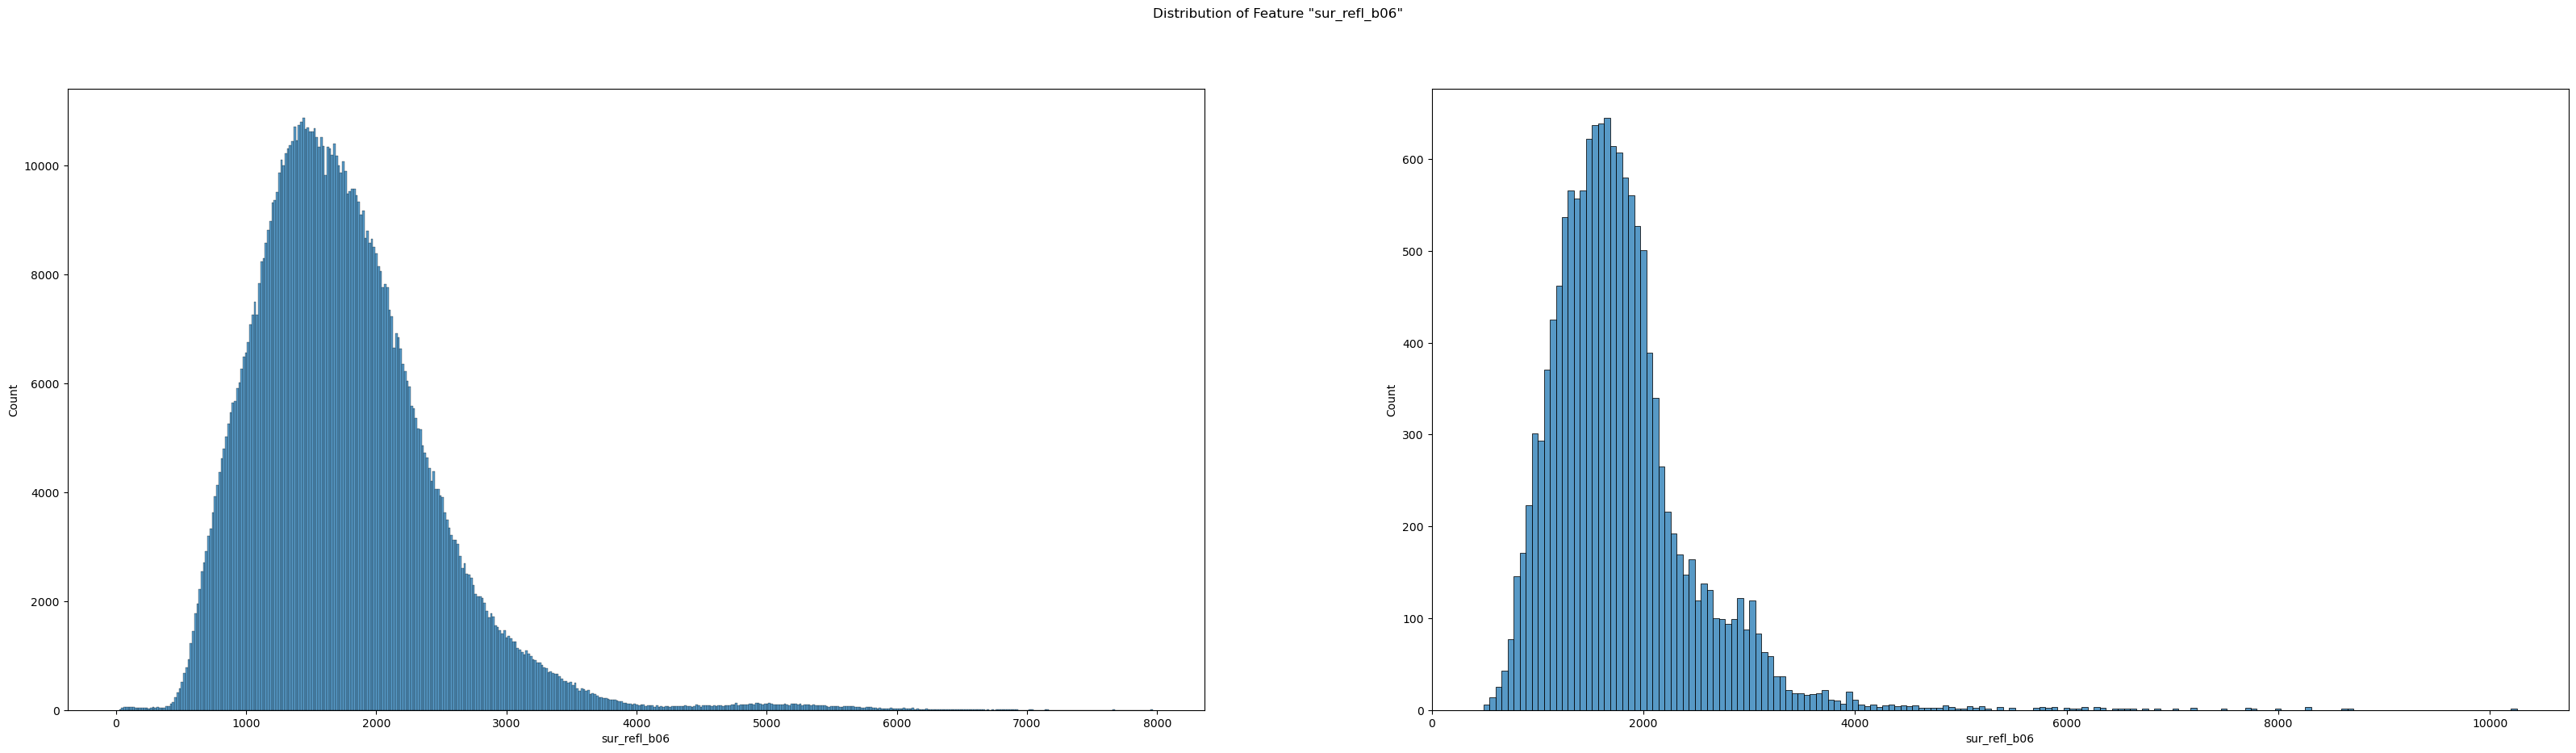

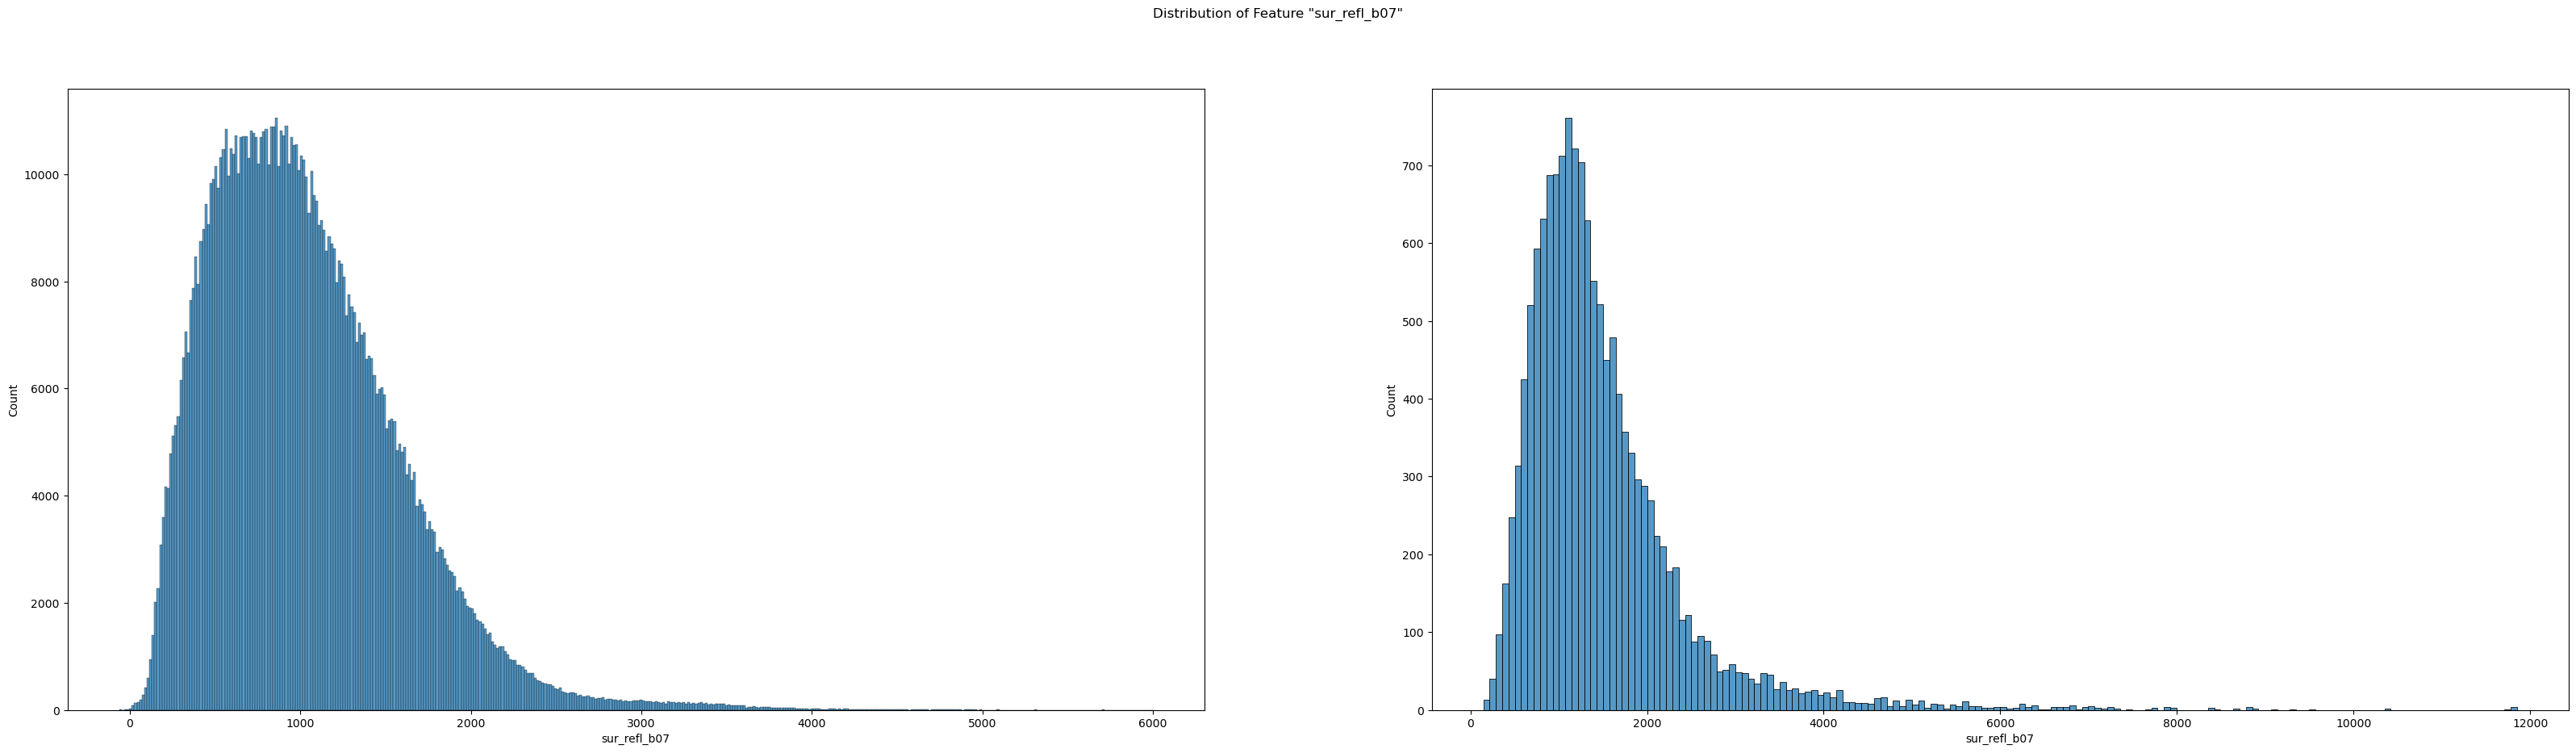

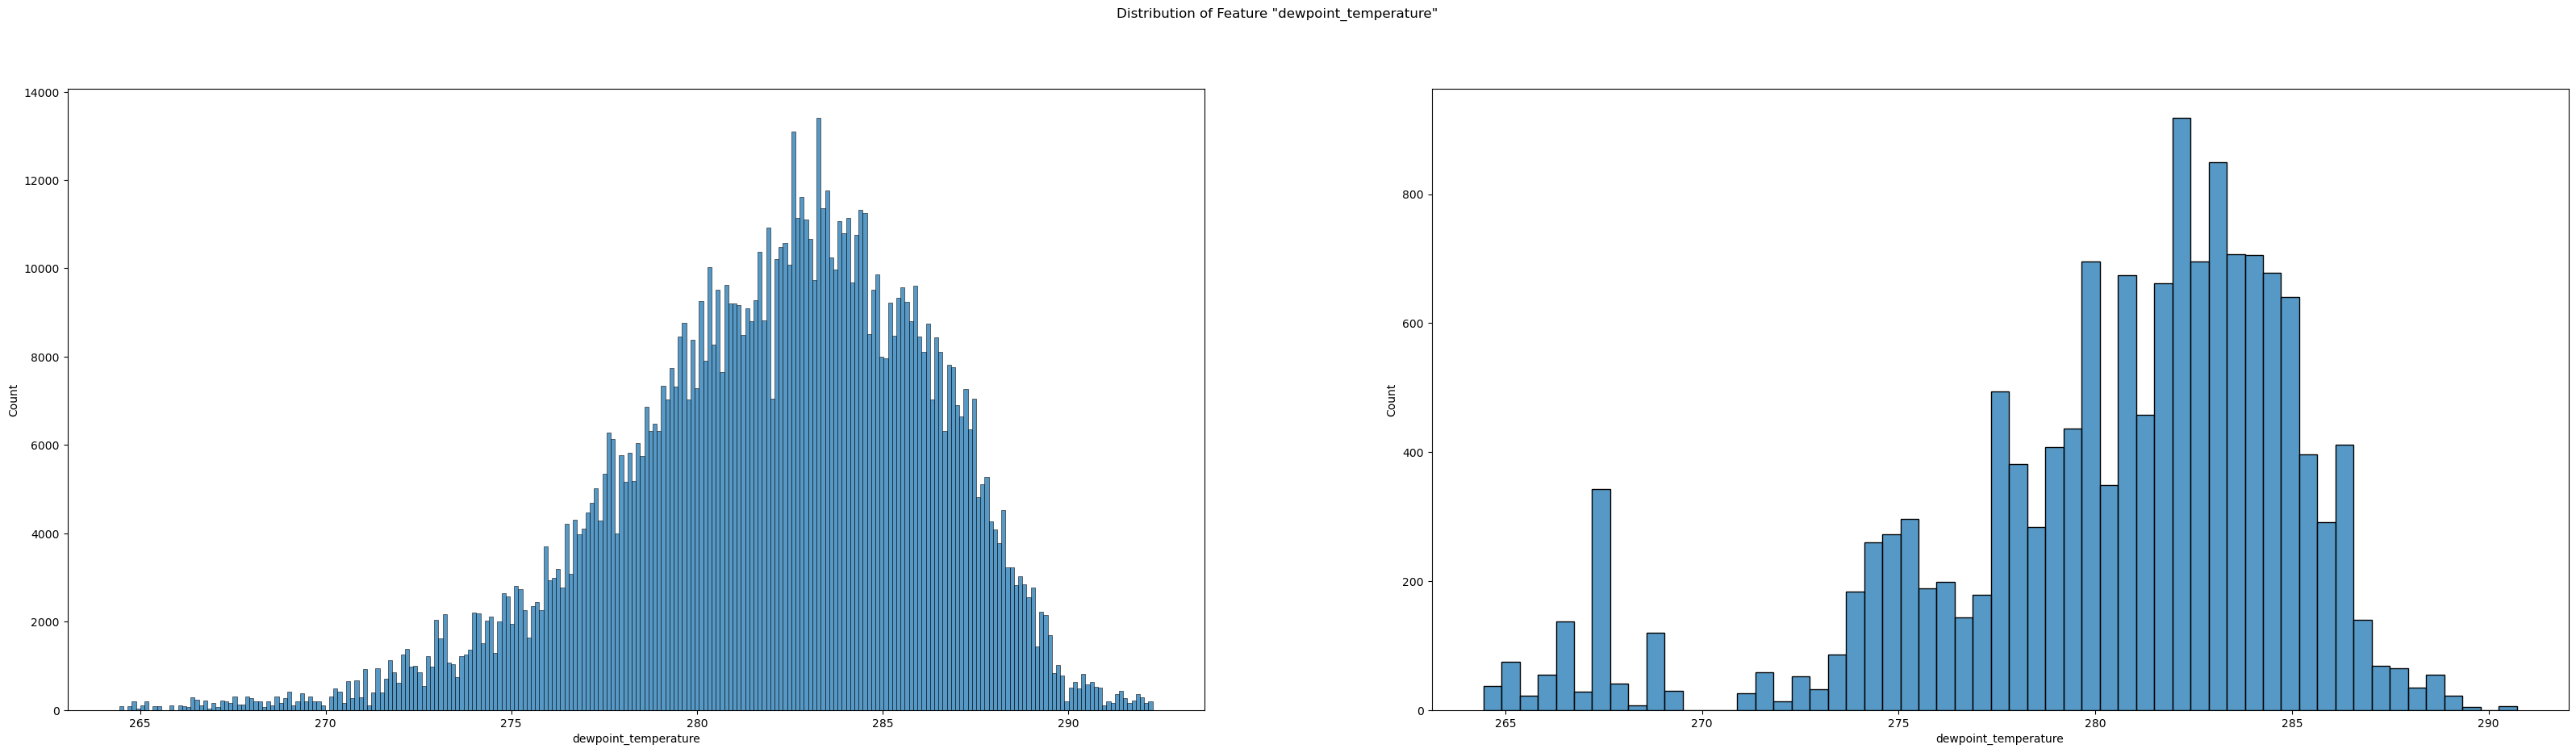

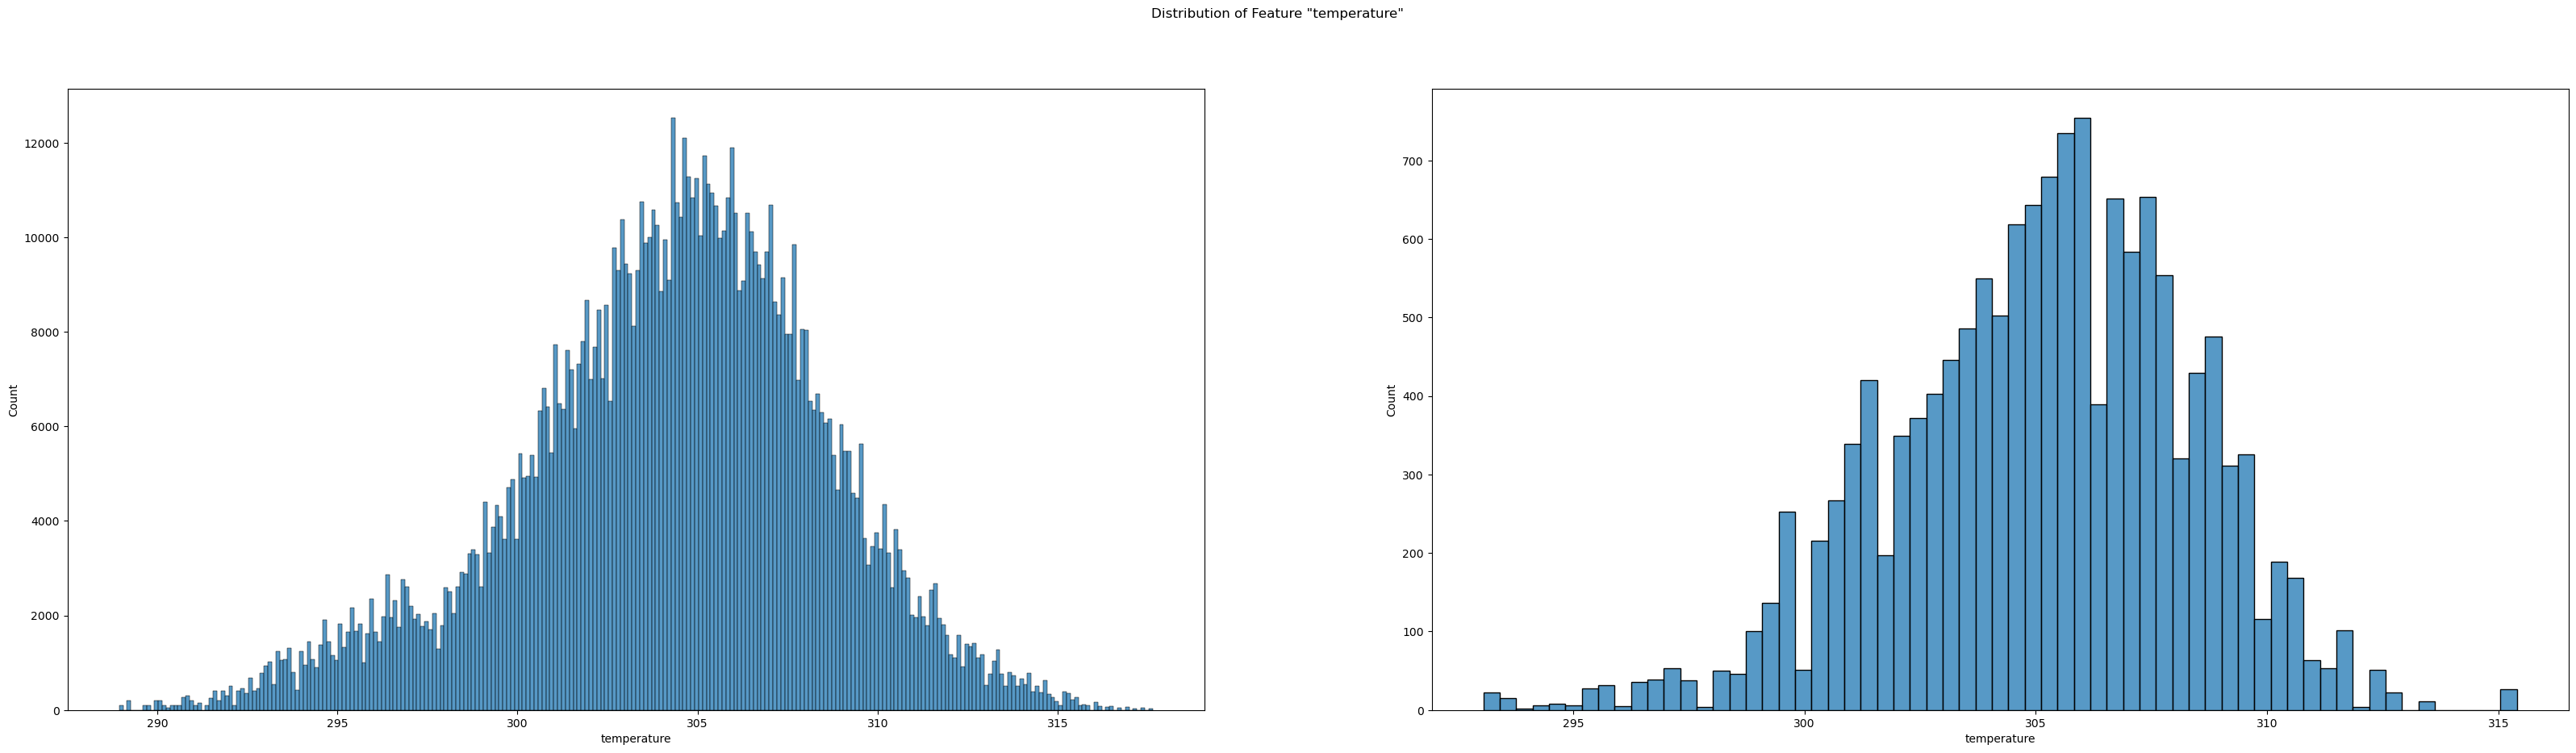

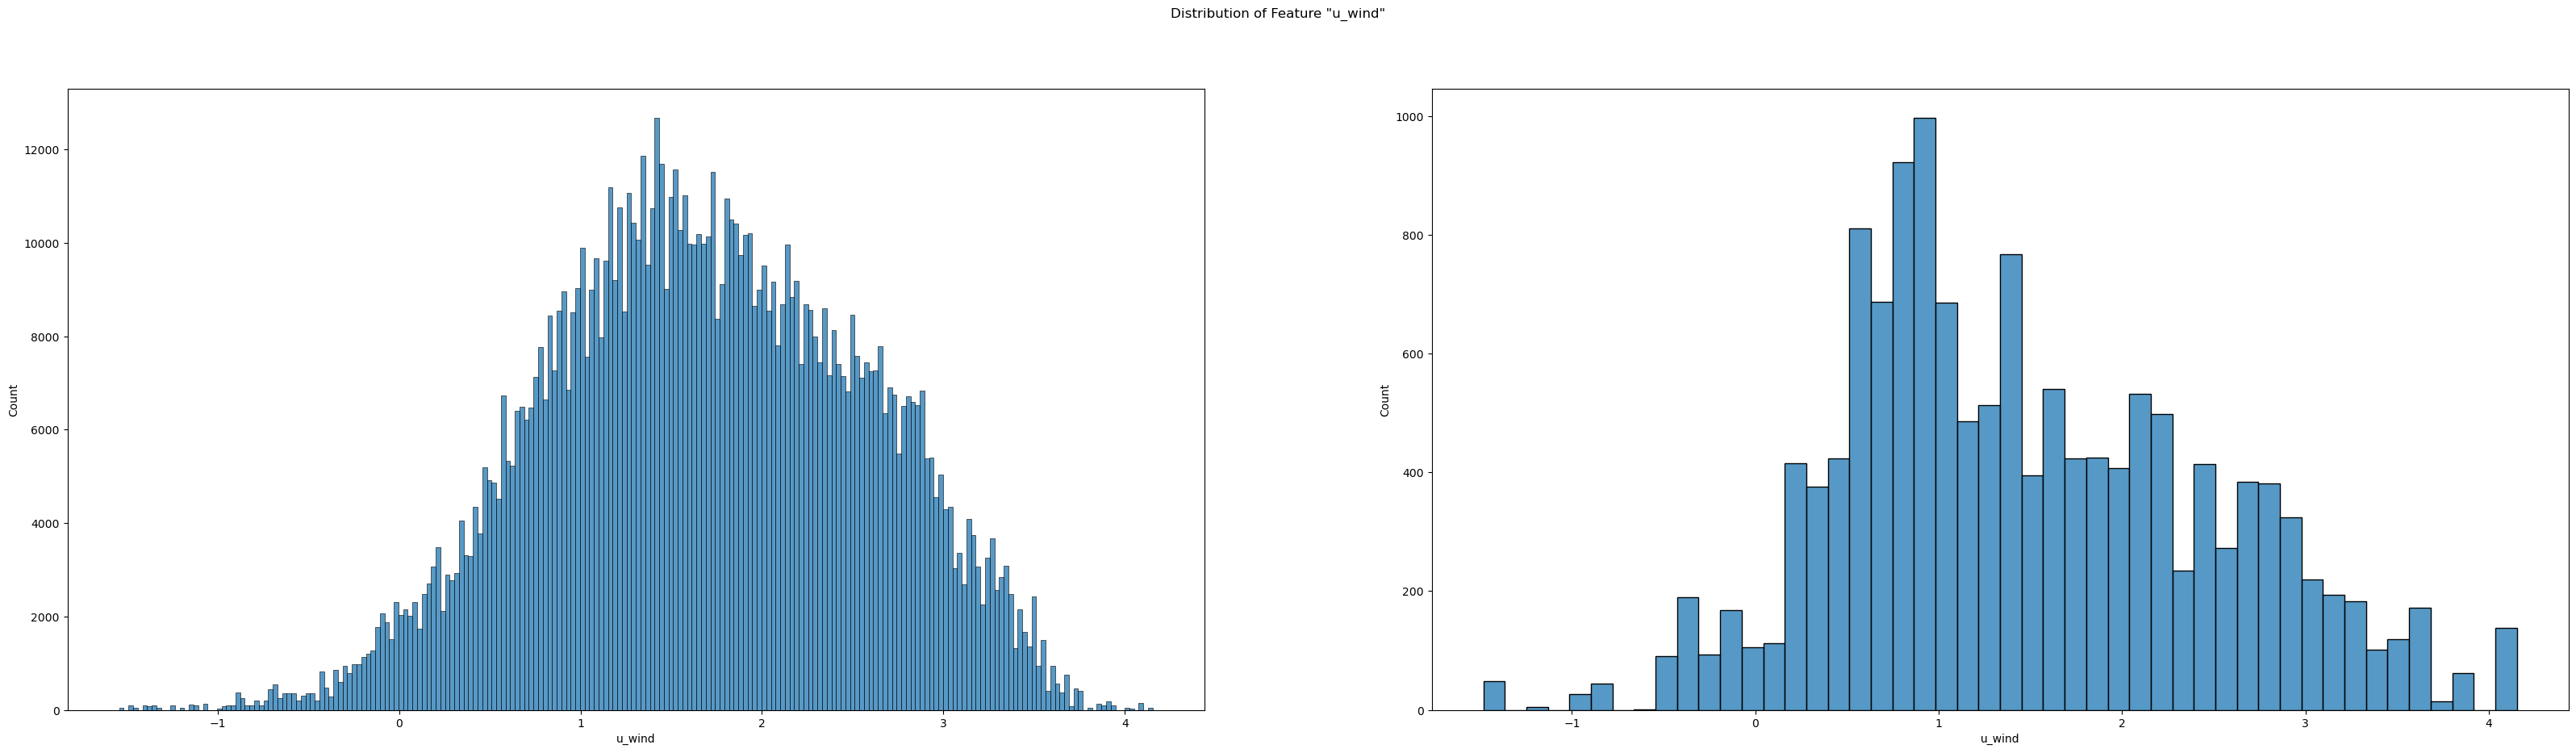

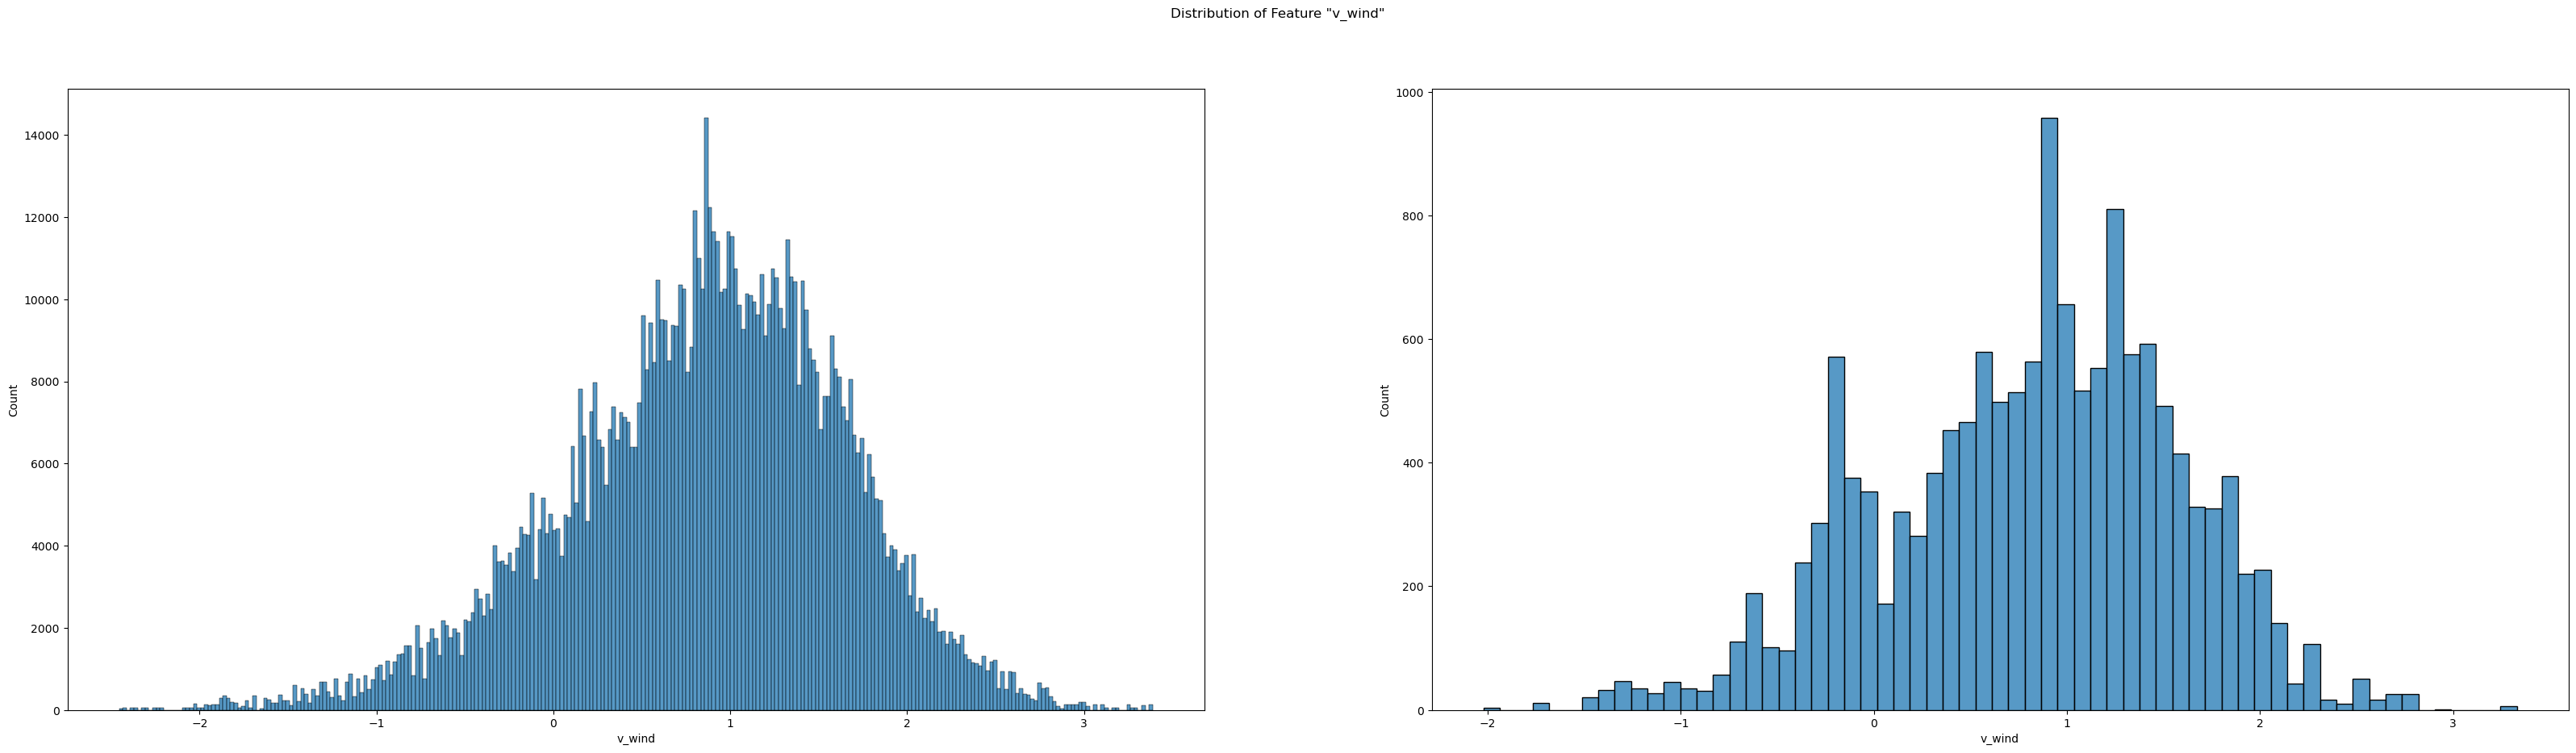

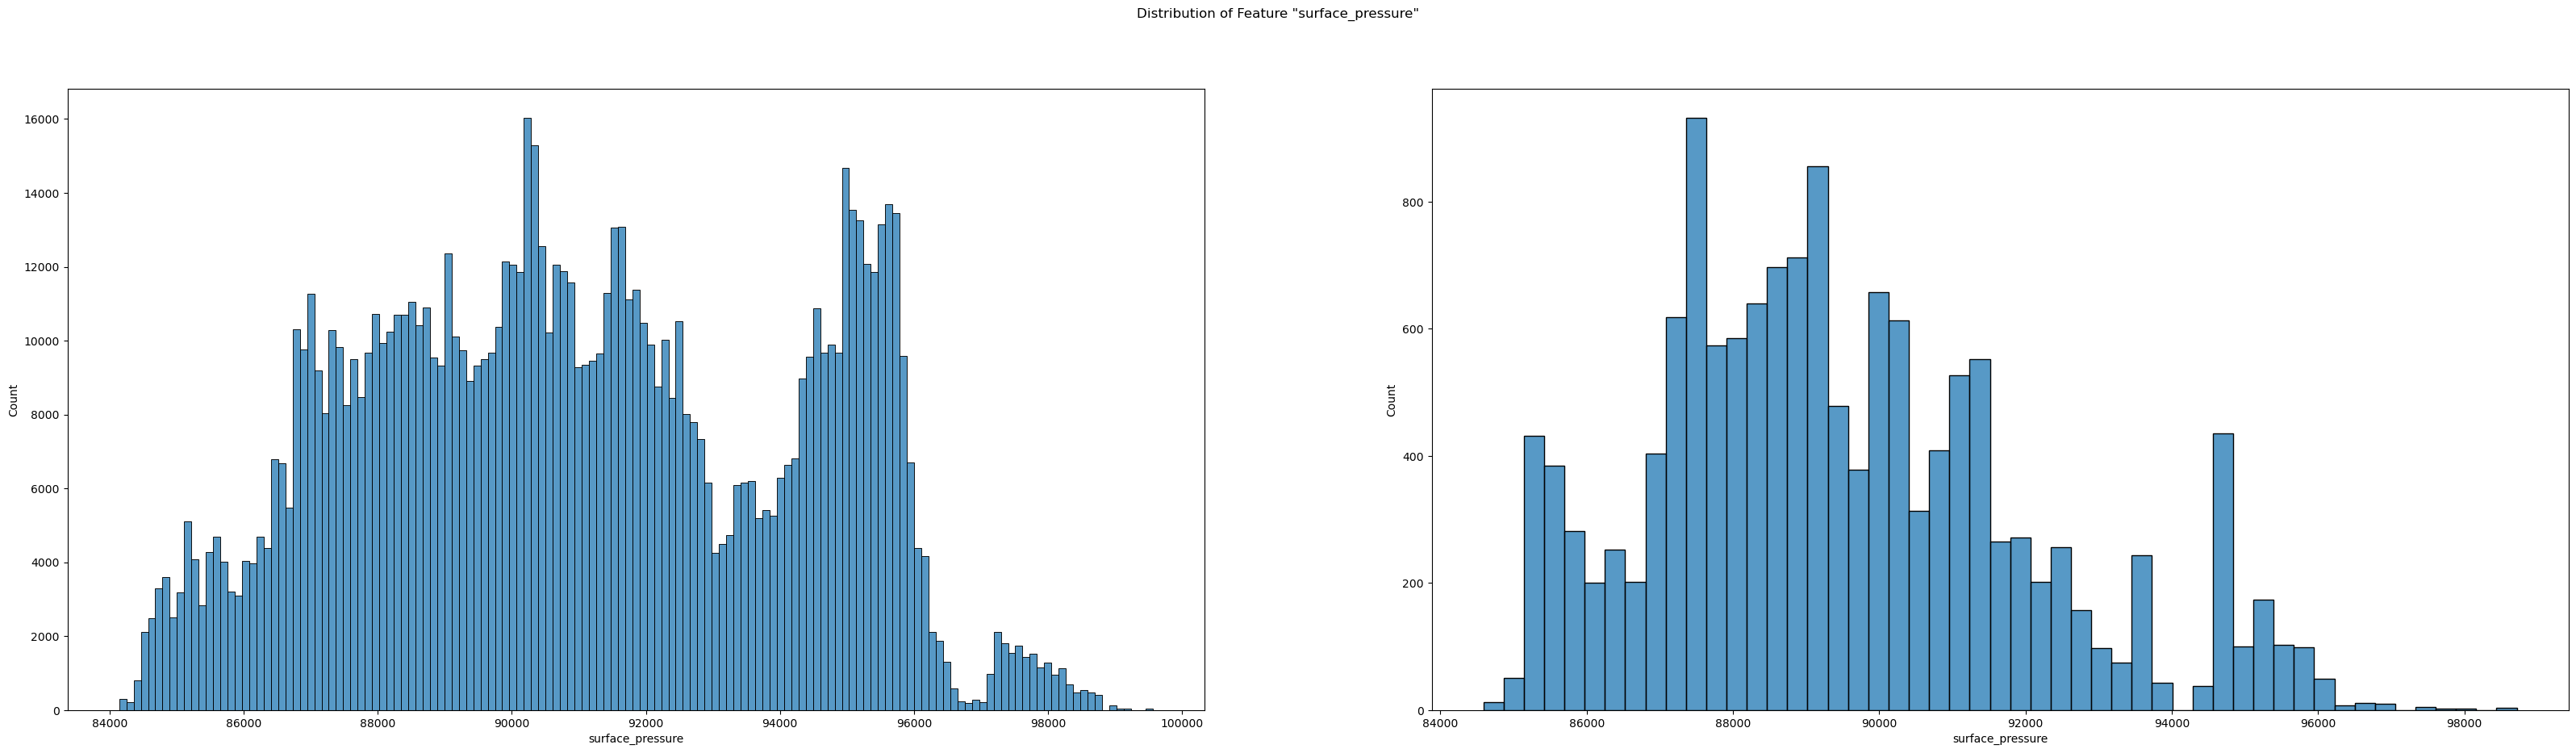

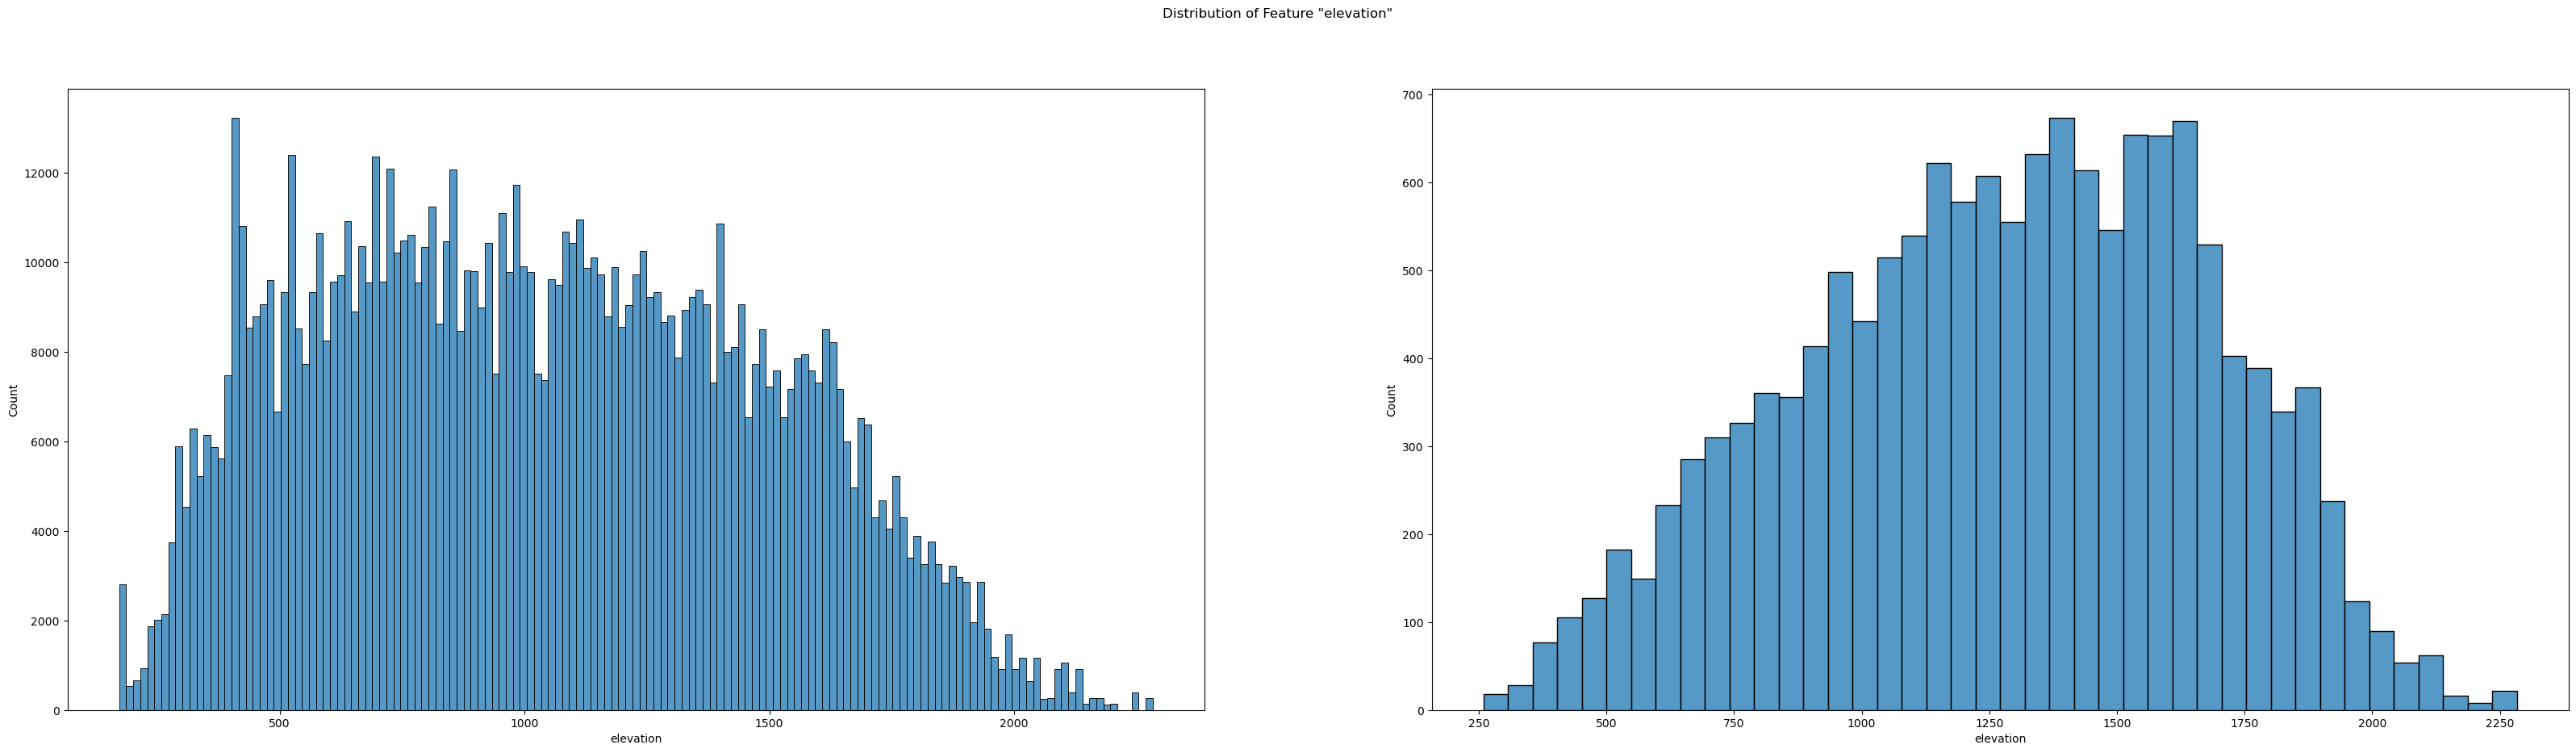

In [8]:
features = [
    'lst_day',
    'lst_night',
    'emis_31',
    'emis_32',
    'sur_refl_b01',
    'sur_refl_b02',
    'sur_refl_b03',
    'sur_refl_b04',
    'sur_refl_b05',
    'sur_refl_b06',
    'sur_refl_b07',
    'dewpoint_temperature',
    'temperature',
    'u_wind',
    'v_wind',
    'surface_pressure',
    'elevation'
]

negative_examples = df[df['fire_today'] == 0]
positive_examples = df[df['fire_today'] == 1]

for feature in features:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40, 10))
    fig.suptitle('Distribution of Feature "%s"' % feature)
    sns.histplot(negative_examples[feature], ax=ax1)
    sns.histplot(positive_examples[feature], ax=ax2)
    plt.show()

The graphs above are separated into no fire (`fire_today` = $0$) in the first column and fire (`fire_today` = $1$) in the second column. Ignoring the features `date`, `longitude`, `latitude`, `region`, `month`, and `year` a few patterns seem to emerge for the remaining numeric features:

* The `Surface Reflection` features appear positively skewed
* The `Land Surface Temperature`, `Dewpoint Temperature`, `Temperature`, and `Wind` features appear normally distributed
* `sur_refl_b01`, `sur_refl_b03`, and `sur_refl_b04` are centered ~$500$ for no fire and ~$2,000$ for fire
* `elevation` is centered ~$1,000$ for no fire and ~$1,300$ for fire

<br>

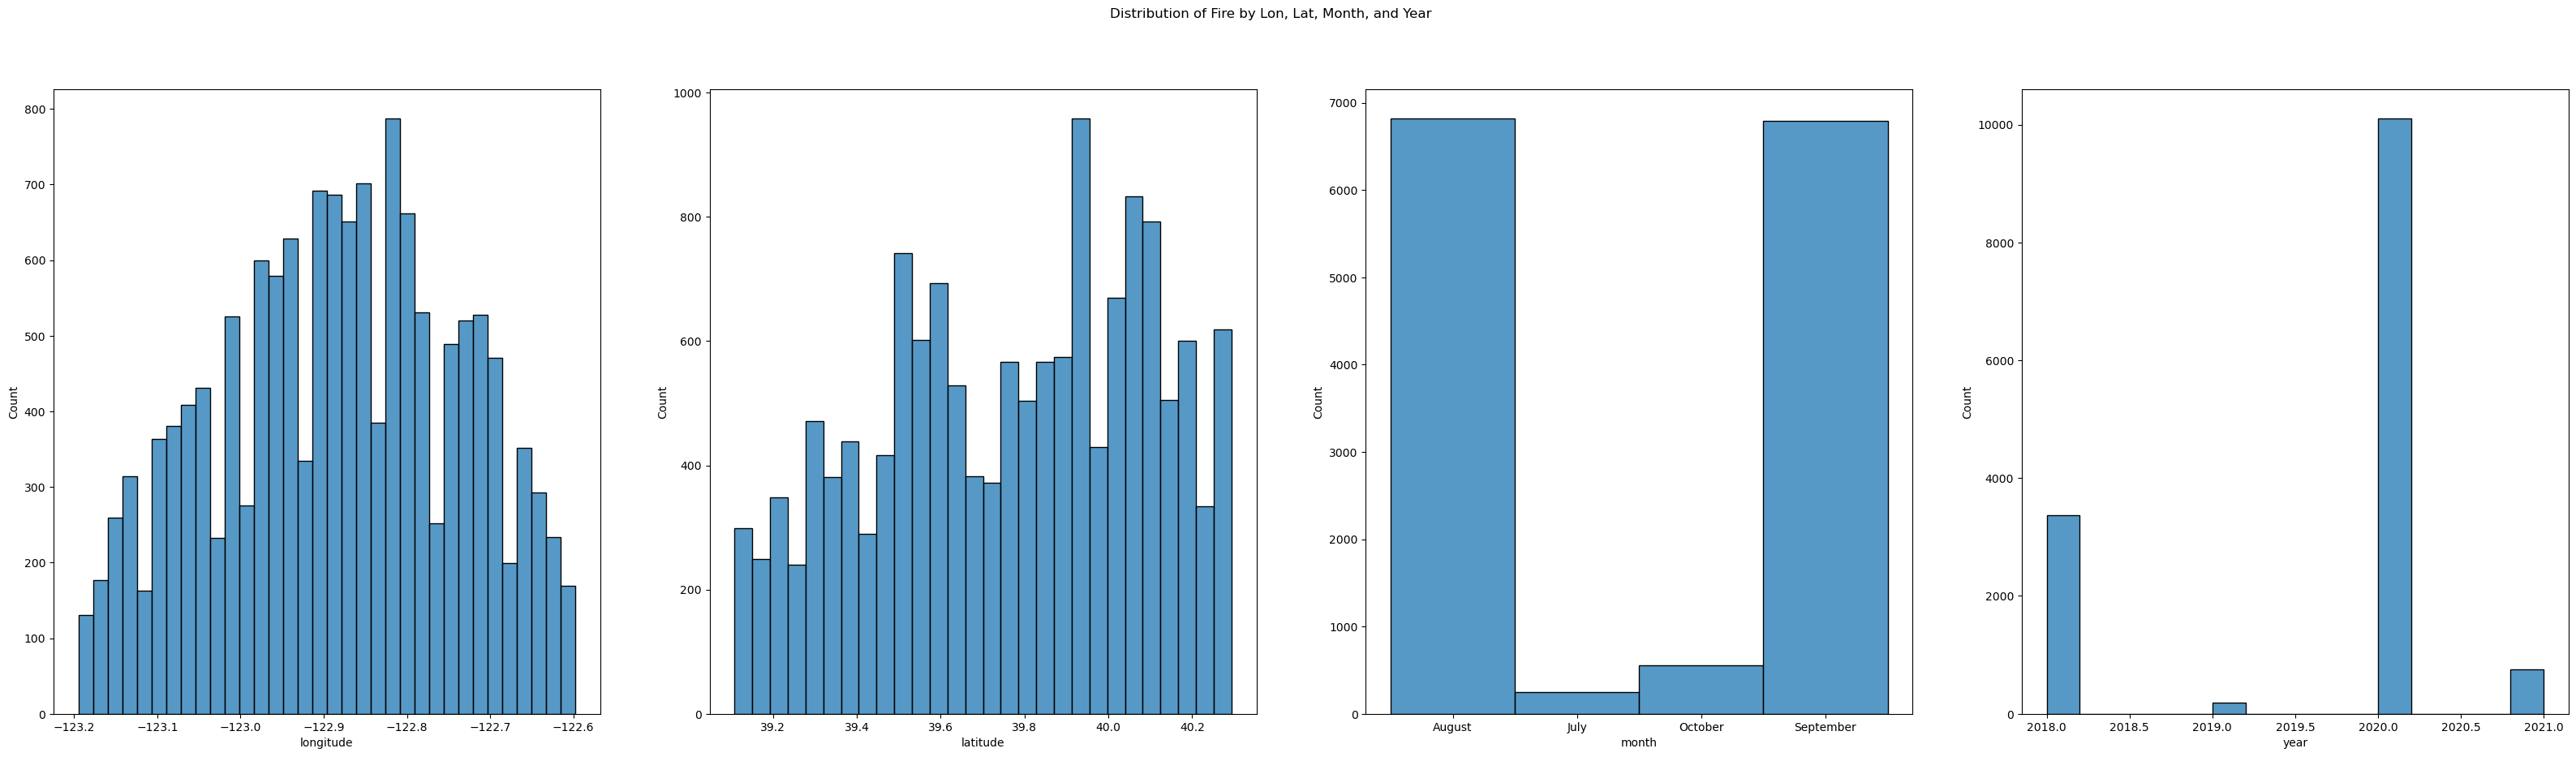

In [9]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(40, 10))
fig.suptitle('Distribution of Fire by Lon, Lat, Month, and Year')
sns.histplot(positive_examples['longitude'], ax=ax1)
sns.histplot(positive_examples['latitude'], ax=ax2)
sns.histplot(positive_examples['month'], ax=ax3)
sns.histplot(positive_examples['year'], ax=ax4)
plt.show()

The four graphs above show the count of fire occurrences per `longitude`, `latitude`, `month`, and `year`. Looking at the `longitude` graph, it appears that more wildfires are occurring in the Eastern regions of Mendocino National Forest. Moreover, looking at the `latitude` graph, it appears that more wildfires are occurring in the Northern regions of Mendocino National Forest. Examining the `month` graph, it seems that August and September experience relatively similar levels of wildfire. Lastly, examining the `year` graph, we see that $2018$ and $2020$ were by far the worst years for wildfires. 

<br>

## 4. Feature Engineering
<hr><br>

The main form of feature engineering we'll perform is extracting lagged features from our existing features. Lagged features are simply the values for a given feature from a previous day or days. We'll impute and encode these lagged features exactly the same as their non-lagged counterparts.

In [10]:
lag_features = [
    'fire_today',
    'lst_day',
    'lst_night',
    'emis_31',
    'emis_32',
    'sur_refl_b01',
    'sur_refl_b02',
    'sur_refl_b03',
    'sur_refl_b04',
    'sur_refl_b05',
    'sur_refl_b06',
    'sur_refl_b07',
    'dewpoint_temperature',
    'temperature',
    'u_wind',
    'v_wind',
    'surface_pressure',
    'precipitation'
]

def lagFeatures(df, features, lags, feature_name=None, clip=False, label='lag', sortby=['date'], groupby=['longitude', 'latitude']):
    copy = df.copy()
    copy = copy.sort_values(sortby)
    
    for name, group in copy.groupby(groupby):
        for feature in features:
            for lag in lags:
                if feature_name is not None:
                    copy.loc[group.index, feature_name] = group[feature].shift(lag)
                else:
                    copy.loc[group.index, feature + '_' + label + '_' + str(lag)] = group[feature].shift(lag)
                
    if clip:
        copy = copy.dropna(subset=feature_name)
        
    return copy


lag_df = lagFeatures(df, lag_features, [1, 2, 3, 4, 5])
lag_df = lagFeatures(lag_df, ['fire_today'], [-1], 'fire_tomorrow', True)
lag_df = lag_df.sort_values(['longitude', 'latitude', 'date'])
lag_df

,time,longitude,latitude,fire_today,lst_day,lst_night,emis_31,emis_32,sur_refl_b01,sur_refl_b02,sur_refl_b03,sur_refl_b04,sur_refl_b05,sur_refl_b06,sur_refl_b07,dewpoint_temperature,temperature,u_wind,v_wind,surface_pressure,precipitation,elevation,date,month,year,x,y,fire_today_lag_1,fire_today_lag_2,fire_today_lag_3,fire_today_lag_4,fire_today_lag_5,lst_day_lag_1,lst_day_lag_2,lst_day_lag_3,lst_day_lag_4,lst_day_lag_5,lst_night_lag_1,lst_night_lag_2,lst_night_lag_3,lst_night_lag_4,lst_night_lag_5,emis_31_lag_1,emis_31_lag_2,emis_31_lag_3,emis_31_lag_4,emis_31_lag_5,emis_32_lag_1,emis_32_lag_2,emis_32_lag_3,emis_32_lag_4,emis_32_lag_5,sur_refl_b01_lag_1,sur_refl_b01_lag_2,sur_refl_b01_lag_3,sur_refl_b01_lag_4,sur_refl_b01_lag_5,sur_refl_b02_lag_1,sur_refl_b02_lag_2,sur_refl_b02_lag_3,sur_refl_b02_lag_4,sur_refl_b02_lag_5,sur_refl_b03_lag_1,sur_refl_b03_lag_2,sur_refl_b03_lag_3,sur_refl_b03_lag_4,sur_refl_b03_lag_5,sur_refl_b04_lag_1,sur_refl_b04_lag_2,sur_refl_b04_lag_3,sur_refl_b04_lag_4,sur_refl_b04_lag_5,sur_refl_b05_lag_1,sur_refl_b05_lag_2,sur_refl_b05_lag_3,sur_refl_b05_lag_4,sur_refl_b05_lag_5,sur_refl_b06_lag_1,sur_refl_b06_lag_2,sur_refl_b06_lag_3,sur_refl_b06_lag_4,sur_refl_b06_lag_5,sur_refl_b07_lag_1,sur_refl_b07_lag_2,sur_refl_b07_lag_3,sur_refl_b07_lag_4,sur_refl_b07_lag_5,dewpoint_temperature_lag_1,dewpoint_temperature_lag_2,dewpoint_temperature_lag_3,dewpoint_temperature_lag_4,dewpoint_temperature_lag_5,temperature_lag_1,temperature_lag_2,temperature_lag_3,temperature_lag_4,temperature_lag_5,u_wind_lag_1,u_wind_lag_2,u_wind_lag_3,u_wind_lag_4,u_wind_lag_5,v_wind_lag_1,v_wind_lag_2,v_wind_lag_3,v_wind_lag_4,v_wind_lag_5,surface_pressure_lag_1,surface_pressure_lag_2,surface_pressure_lag_3,surface_pressure_lag_4,surface_pressure_lag_5,precipitation_lag_1,precipitation_lag_2,precipitation_lag_3,precipitation_lag_4,precipitation_lag_5,fire_tomorrow
208,1532736000000,-123.194958,39.108156,0,15628.0,14711.0,245.5,247.0,669.0,2512.5,356.0,608.5,2421.5,1734.0,983.5,285.476746,307.758743,3.046509,0.193535,95564.093750,8.457610e-07,190.0,2018-07-28,July,2018,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
209,1532822400000,-123.194958,39.108156,0,15745.5,14639.0,246.0,247.5,1127.5,3582.0,568.0,991.0,3861.5,2985.0,1783.5,285.721069,306.486847,2.802200,-0.059257,95703.417969,1.018643e-05,190.0,2018-07-29,July,2018,0.0,0.0,0.0,NaN,NaN,NaN,NaN,15628.0,NaN,NaN,NaN,NaN,14711.0,NaN,NaN,NaN,NaN,245.5,NaN,NaN,NaN,NaN,247.0,NaN,NaN,NaN,NaN,669.0,NaN,NaN,NaN,NaN,2512.5,NaN,NaN,NaN,NaN,356.0,NaN,NaN,NaN,NaN,608.5,NaN,NaN,NaN,NaN,2421.5,NaN,NaN,NaN,NaN,1734.0,NaN,NaN,NaN,NaN,983.5,NaN,NaN,NaN,NaN,285.476746,NaN,NaN,NaN,NaN,307.758743,NaN,NaN,NaN,NaN,3.046509,NaN,NaN,NaN,NaN,0.193535,NaN,NaN,NaN,NaN,95564.093750,NaN,NaN,NaN,NaN,8.457610e-07,NaN,NaN,NaN,NaN,0.0
210,1532908800000,-123.194958,39.108156,0,15719.5,14632.0,245.5,247.0,684.5,2484.0,355.5,608.0,2423.0,1803.0,998.5,284.861404,306.058380,2.819260,-0.758291,95697.886719,1.034141e-05,190.0,2018-07-30,July,2018,0.0,0.0,0.0,0.0,NaN,NaN,NaN,15745.5,15628.0,NaN,NaN,NaN,14639.0,14711.0,NaN,NaN,NaN,246.0,245.5,NaN,NaN,NaN,247.5,247.0,NaN,NaN,NaN,1127.5,669.0,NaN,NaN,NaN,3582.0,2512.5,NaN,NaN,NaN,568.0,356.0,NaN,NaN,NaN,991.0,608.5,NaN,NaN,NaN,3861.5,2421.5,NaN,NaN,NaN,2985.0,1734.0,NaN,NaN,NaN,1783.5,983.5,NaN,NaN,NaN,285.721069,285.476746,NaN,NaN,NaN,306.486847,307.758743,NaN,NaN,NaN,2.802200,3.046509,NaN,NaN,NaN,-0.059257,0.193535,NaN,NaN,NaN,95703.417969,95564.093750,NaN,NaN,NaN,1.018643e-05,8.457610e-07,NaN,NaN,NaN,0.0
211,1532995200000,-123.194958,39.108156,0,15622.0,14567.0,246.0,247.5,1024.0,3532.0,529.5,931.0,3630.5,2731.5,1541.5,285.624969,306.540482,2.865234

For each of our numeric features, we now have a lagged version of that feature for the previous three days. Going row by row you can see the triangular pattern of NaNs appearing as features begin to be lagged. The first row, of course, contains NaNs for all our lagged features as it has no previous day to extract data from. Most importantly, we have defined our target variable for this analysis - `fire_tomorrow` - by looking at the `fire_today` field for the following day and extracting that as our target. This will allow us to train our model in a way that ideally allow us to predict if fire will occur the following day. The goal is forecasting wildfires so that individuals and organizations can act in a preemptive manner.

<br>

## 5. Data Splitting
<hr><br>

Because our dataset is a time series, we are unable to randomly split our data using conventional methods like `train_test_split`. Instead, we will take all data before $2021$ as our training set and all data after this point, all of $2021$, as our testing set. 

In [12]:
train_df = lag_df.query('date < 20210101')
test_df = lag_df.query('date >= 20210101')
print('Ratio of Training data: %.3f' % (len(train_df) / (len(train_df) + len(test_df))))

Ratio of Training data: 0.857


<br>

## 6. Preprocessing & Transformations 
<hr><br>

In [14]:
X_train = train_df.drop(columns=['fire_tomorrow'])
X_test = test_df.drop(columns=['fire_tomorrow'])
y_train = train_df['fire_tomorrow']
y_test = test_df['fire_tomorrow']

passthrough_features = [
    'fire_today'
]

drop_features = [
    'date',
    'longitude',
    'latitude'
]

categorical_features = [
    'month',
    'year'
]

binary_features = [
    'fire_today_lag_1',
    'fire_today_lag_2',
    'fire_today_lag_3',
    'fire_today_lag_4',
    'fire_today_lag_5'
]

numeric_features = [
    'x',
    'y',
    'time',
    'elevation',
    'lst_day',
    'lst_day_lag_1',
    'lst_day_lag_2',
    'lst_day_lag_3',
    'lst_day_lag_4',
    'lst_day_lag_5',
    'lst_night',
    'lst_night_lag_1',
    'lst_night_lag_2',
    'lst_night_lag_3',
    'lst_night_lag_4',
    'lst_night_lag_5',
    'emis_31',
    'emis_31_lag_1',
    'emis_31_lag_2',
    'emis_31_lag_3',
    'emis_31_lag_4',
    'emis_31_lag_5',
    'emis_32',
    'emis_32_lag_1',
    'emis_32_lag_2',
    'emis_32_lag_3',
    'emis_32_lag_4',
    'emis_32_lag_5',
    'sur_refl_b01',
    'sur_refl_b01_lag_1',
    'sur_refl_b01_lag_2',
    'sur_refl_b01_lag_3',
    'sur_refl_b01_lag_4',
    'sur_refl_b01_lag_5',
    'sur_refl_b02',
    'sur_refl_b02_lag_1',
    'sur_refl_b02_lag_2',
    'sur_refl_b02_lag_3',
    'sur_refl_b02_lag_4',
    'sur_refl_b02_lag_5',
    'sur_refl_b03',
    'sur_refl_b03_lag_1',
    'sur_refl_b03_lag_2',
    'sur_refl_b03_lag_3',
    'sur_refl_b03_lag_4',
    'sur_refl_b03_lag_5',
    'sur_refl_b04',
    'sur_refl_b04_lag_1',
    'sur_refl_b04_lag_2',
    'sur_refl_b04_lag_3',
    'sur_refl_b04_lag_4',
    'sur_refl_b04_lag_5',
    'sur_refl_b05',
    'sur_refl_b05_lag_1',
    'sur_refl_b05_lag_2',
    'sur_refl_b05_lag_3',
    'sur_refl_b05_lag_4',
    'sur_refl_b05_lag_5',
    'sur_refl_b06',
    'sur_refl_b06_lag_1',
    'sur_refl_b06_lag_2',
    'sur_refl_b06_lag_3',
    'sur_refl_b06_lag_4',
    'sur_refl_b06_lag_5',
    'sur_refl_b07',
    'sur_refl_b07_lag_1',
    'sur_refl_b07_lag_2',
    'sur_refl_b07_lag_3',
    'sur_refl_b07_lag_4',
    'sur_refl_b07_lag_5',
    'dewpoint_temperature',
    'dewpoint_temperature_lag_1',
    'dewpoint_temperature_lag_2',
    'dewpoint_temperature_lag_3',
    'dewpoint_temperature_lag_4',
    'dewpoint_temperature_lag_5',
    'temperature',
    'temperature_lag_1',
    'temperature_lag_2',
    'temperature_lag_3',
    'temperature_lag_4',
    'temperature_lag_5',
    'u_wind',
    'u_wind_lag_1',
    'u_wind_lag_2',
    'u_wind_lag_3',
    'u_wind_lag_4',
    'u_wind_lag_5',
    'v_wind',
    'v_wind_lag_1',
    'v_wind_lag_2',
    'v_wind_lag_3',
    'v_wind_lag_4',
    'v_wind_lag_5',
    'surface_pressure',
    'surface_pressure_lag_1',
    'surface_pressure_lag_2',
    'surface_pressure_lag_3',
    'surface_pressure_lag_4',
    'surface_pressure_lag_5',
    'precipitation',
    'precipitation_lag_1',
    'precipitation_lag_2',
    'precipitation_lag_3',
    'precipitation_lag_4',
    'precipitation_lag_5'
]
  
preprocessor = make_column_transformer(
    ('passthrough', passthrough_features),
    ('drop', drop_features),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features),
    (SimpleImputer(strategy='most_frequent'), binary_features),
    (make_pipeline(SimpleImputer(), StandardScaler()), numeric_features)
)

As we stated above, with the exception of `date` and `month`, all of our features are numeric. Therefore, we will use `SimpleImputer` and `StandardScaler` to impute and scale our feature values, respectively. For the `month`, and `year` features we will treat these as categorical variables and use one-hot encoding, creating a new column for each unique value these features can take on. We have decided to drop the `date`, `longitude`, and `latitude` fields as they likely won't provide our model with any useful information beyond what we've already been able to extract. Of course, we could try different approaches to data transformations to potentially improve the model after our analysis is complete.

<br>

## 7. Evaluating Classifiers without Class Balancing
<hr><br>

In [16]:
columns = ['Model', 'AP Train Score', 'AP Test Score', 'ROC Train Score', 'ROC Test Score']
models = {
    'RandomForestClassifier': RandomForestClassifier(),
    'XGBClassifier': XGBClassifier(),
    'LGBMClassifier': LGBMClassifier()
}

def crossValidateSummary(model, X_train, y_train, scoring=['average_precision', 'roc_auc']):
    scores = cross_validate(
        model, 
        X_train, 
        y_train,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1
    )
    
    return [
        ('%0.3f (+/- %0.3f)' % (scores['train_average_precision'].mean(), scores['train_average_precision'].std())),
        ('%0.3f (+/- %0.3f)' % (scores['test_average_precision'].mean(), scores['test_average_precision'].std())),
        ('%0.3f (+/- %0.3f)' % (scores['train_roc_auc'].mean(), scores['train_roc_auc'].std())),
        ('%0.3f (+/- %0.3f)' % (scores['test_roc_auc'].mean(), scores['test_roc_auc'].std()))
    ]

def evaluateModels(X_train=X_train, y_train=y_train, models=models, preprocessor=preprocessor, sampler=False, label=None):
    summary = []
    
    for name, model in models.items():
        pipe = make_pipeline(preprocessor, model) if sampler is False else imb_make_pipeline(preprocessor, SMOTE(), model)
        scores = crossValidateSummary(pipe, X_train, y_train)
        summary.append([name if label is None else name + ' ' + label, scores[0], scores[1], scores[2], scores[3]])
        
    return summary

summary = evaluateModels()
pd.DataFrame(summary, columns=columns).set_index('Model')

,AP Train Score,AP Test Score,ROC Train Score,ROC Test Score
Model,,,,
RandomForestClassifier,1.000 (+/- 0.000),0.344 (+/- 0.063),1.000 (+/- 0.000),0.933 (+/- 0.023)
XGBClassifier,0.902 (+/- 0.015),0.206 (+/- 0.105),0.997 (+/- 0.000),0.853 (+/- 0.126)
LGBMClassifier,0.728 (+/- 0.023),0.128 (+/- 0.051),0.992 (+/- 0.001),0.862 (+/- 0.072)


Examining the scores above, it appears that our `LogisticRegression` model obtains the best `roc_auc` test score ($0.962$), followed by our `XGBClassifier` model ($0.887$), and then our `LGBMClassifier` model ($0.812$). For all three models, the `average_precision` test scores are much worse than the `roc_auc` test scores. This is likely due to the fact that we have so few positive examples ($0.13$%). Furthermore, if we examine the `roc_auc` training scores, it appears the `LogisticRegression` and `XGBClassifier` models are overfitting as they score close to $100$%. Before we perform hyperparameter optimization, it may benefit our models to use a technique like SMOTE to balance our data.

<br>

## 8. Evaluating Classifiers with Model-Based Class Balancing
<hr><br>

In [17]:
scale_pos_weight = np.bincount(y_train)[0]/np.bincount(y_train)[1]
weight_models = {
    'RandomForestClassifier': RandomForestClassifier(class_weight='balanced'),
    'XGBClassifier': XGBClassifier(scale_pos_weight=scale_pos_weight),
    'LGBMClassifier': LGBMClassifier(scale_pos_weight=scale_pos_weight)
}

weight_summary = evaluateModels(models=weight_models, label='(weight)')
pd.DataFrame(np.concatenate((summary, weight_summary)), columns=columns).set_index('Model')

,AP Train Score,AP Test Score,ROC Train Score,ROC Test Score
Model,,,,
RandomForestClassifier,1.000 (+/- 0.000),0.344 (+/- 0.063),1.000 (+/- 0.000),0.933 (+/- 0.023)
XGBClassifier,0.902 (+/- 0.015),0.206 (+/- 0.105),0.997 (+/- 0.000),0.853 (+/- 0.126)
LGBMClassifier,0.728 (+/- 0.023),0.128 (+/- 0.051),0.992 (+/- 0.001),0.862 (+/- 0.072)
RandomForestClassifier (weight),1.000 (+/- 0.000),0.299 (+/- 0.047),1.000 (+/- 0.000),0.894 (+/- 0.068)
XGBClassifier (weight),0.810 (+/- 0.025),0.218 (+/- 0.071),0.997 (+/- 0.000),0.872 (+/- 0.092)
LGBMClassifier (weight),0.594 (+/- 0.030),0.254 (+/- 0.099),0.991 (+/- 0.001),0.886 (+/- 0.079)


Examining the scores above, it appears that our `LogisticRegression` model obtains the best `roc_auc` test score ($0.962$), followed by our `XGBClassifier` model ($0.887$), and then our `LGBMClassifier` model ($0.812$). For all three models, the `average_precision` test scores are much worse than the `roc_auc` test scores. This is likely due to the fact that we have so few positive examples ($0.13$%). Furthermore, if we examine the `roc_auc` training scores, it appears the `LogisticRegression` and `XGBClassifier` models are overfitting as they score close to $100$%. Before we perform hyperparameter optimization, it may benefit our models to use a technique like SMOTE to balance our data.

<br>

## 9. Evaluating Classifiers with Sampling-Based Class Balancing
<hr><br>

In [18]:
smote_summary = evaluateModels(sampler=True, label='(smote)')
pd.DataFrame(np.concatenate((summary, weight_summary, smote_summary)), columns=columns).set_index('Model')

,AP Train Score,AP Test Score,ROC Train Score,ROC Test Score
Model,,,,
RandomForestClassifier,1.000 (+/- 0.000),0.344 (+/- 0.063),1.000 (+/- 0.000),0.933 (+/- 0.023)
XGBClassifier,0.902 (+/- 0.015),0.206 (+/- 0.105),0.997 (+/- 0.000),0.853 (+/- 0.126)
LGBMClassifier,0.728 (+/- 0.023),0.128 (+/- 0.051),0.992 (+/- 0.001),0.862 (+/- 0.072)
RandomForestClassifier (weight),1.000 (+/- 0.000),0.299 (+/- 0.047),1.000 (+/- 0.000),0.894 (+/- 0.068)
XGBClassifier (weight),0.810 (+/- 0.025),0.218 (+/- 0.071),0.997 (+/- 0.000),0.872 (+/- 0.092)
LGBMClassifier (weight),0.594 (+/- 0.030),0.254 (+/- 0.099),0.991 (+/- 0.001),0.886 (+/- 0.079)
RandomForestClassifier (smote),1.000 (+/- 0.000),0.349 (+/- 0.048),1.000 (+/- 0.000),0.935 (+/- 0.031)
XGBClassifier (smote),0.748 (+/- 0.030),0.237 (+/- 0.058),0.993 (+/- 0.001),0.876 (+/- 0.093)
LGBMClassifier (smote),0.554 (+/- 0.029),0.293 (+/- 0.079),0.985 (+/- 0.001),0.908 (+/- 0.069)


Examining the scores above, it appears that switching from a model-based class balancing approach to a sampling-based balancing approach has improved all of our models quite a bit. Our `LogisticRegression` model obtains the best `roc_auc` test score ($0.962$), followed by our `LGBMClassifier` model ($0.941$), and then our `XGBClassifier` model ($0.932$). Once again, for all three models, the `average_precision` test scores are much worse than the `roc_auc` test scores. Furthermore, if we examine the `roc_auc` training scores, it appears that all of our models are overfitting as they score close to $100$%. Next we will perform hyperparameter optimization on our `LGBMClassifier` model.

<br>

## 10. Hyperparameter Optimization
<hr><br>

In [ ]:
lgbm_random_search = RandomizedSearchCV(
    imb_make_pipeline(preprocessor, SMOTE(), LGBMClassifier()), 
    {
        'lgbmclassifier__boosting_type': ['gbdt', 'dart'],
        'lgbmclassifier__learning_rate': [0.01, 0.05, 0.1, 0.15, 0.3],
        'lgbmclassifier__max_bin': [100, 200, 300, 400, 500],
        'lgbmclassifier__n_estimators': [50, 75, 100, 125, 150],
        'lgbmclassifier__num_leaves': [10, 20, 30, 40, 50],

    }, 
    scoring='roc_auc',
    return_train_score=True,
    n_iter=100,
    n_jobs=-1,
)

lgbm_random_search.fit(X_train, y_train)
print('Best hyperparameter values: ', lgbm_random_search.best_params_)
print('Best score: %0.3f' % lgbm_random_search.best_score_)

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


<br>

In [ ]:
pd.DataFrame(lgbm_random_search.cv_results_)[[
    'rank_test_score',
    'mean_fit_time',
    'mean_train_score',
    'mean_test_score',
    'param_lgbmclassifier__boosting_type',
    'param_lgbmclassifier__learning_rate',
    'param_lgbmclassifier__max_bin',
    'param_lgbmclassifier__n_estimators',
    'param_lgbmclassifier__num_leaves',
]].set_index('rank_test_score').sort_index().head(20)

<br>

In [ ]:
best_lgbm_model = lgbm_random_search.best_estimator_
scores = crossValidateSummary(best_lgbm_model, X_train, y_train)
pd.DataFrame(np.concatenate((summary, smote_summary, [['LGBMClassifier (tuned w/ smote)', scores[0], scores[1], scores[2], scores[3]]])), columns=columns).set_index('Model')

Using `RandomizedSearchCV` we were able to perform hyperparameter optimization on our `LGBMClassifier` model. Examining the table above, we see that our tuned `LGBMClassifier` model performs much better, obtaining a `roc_auc` test score of $0.979$! There could be a number of reasons for this. First, our model may have simply lucked out during testing and scored exceptionally well. However, it could be that this combination of hyperparameters reduces overfitting and increases prediction performance. The default values for `boosting_type`, `learning_rate`, `max_bin`, `n_estimators`, and `num_leaves` are `gbdt`, $0.1$, $255$, $100$, and $31$, respectively. These would have been the hyperparameter values our untuned `LGBMClassifier` model used. We see above that this combination of hyperparameter values doesn't appear in the top $20$ combinations. It could be, however, that this combination of hyperparameter values wasn't picked by our `RandomizedSearchCV`. Noting the `mean_fit_time` for each run, this search took ~$3$ hours to complete!

<br>

## 11. Feature Interpretation
<hr><br>

In [ ]:
categorical_OHE = list(
    best_lgbm_model
    .named_steps['columntransformer']
    .named_transformers_['onehotencoder']
    .get_feature_names_out(categorical_features)
)
feature_names = passthrough_features + binary_features + numeric_features + categorical_OHE
eli5.show_weights(best_lgbm_model.named_steps["lgbmclassifier"], feature_names=feature_names)

The above table, calculated using the library `eli5`, displays the weight our tuned model gave to each of our features. The higher the weight, the higher the importance of the feature when predicting our target variable `fire_tomorrow`. As we can see, our model determined that `region` was the most important feature, giving it a weight of $0.5004$, followed by `month_August` with a weight of $0.1544$ and `time` with a weight of $0.0887$. Perhaps surprising, `fire_today`, the feature we used to calculate our target variable, doesn't appear in the table. Meaning our model determined it wasn't useful for prediction. Again, this could be because of the low number of positive examples ($0.13$%) in our dataset.

<br>

## 12. Results on the Test Set
<hr><br>

In [41]:
print('ROC score: %.3f' % roc_auc_score(y_test, best_lgbm_model.predict_proba(X_test)[:, 1]))

ROC score: 0.873


Now that we have tuned our model, we can use it on the test data split to obtain a `roc_auc` score on unseen examples. Recall that earlier that we separated our data in before $2021$ and after including $2021$. Therefore, we see that our tuned model obtains a `roc_auc` score of $0.873$ on our test set. While this isn't entirely great, it is fairly good for a model trained on limited data with a low number of positive examples ($0.13$%). Because we're using the `roc_auc` metric, we calculate the probability our tuned model predicts our target variable, `fire_tomorrow`, using the function `predict_proba`. Again, this isn't our tuned model's prediction accuracy on the test set, rather the model's prediction probability. 

<br>

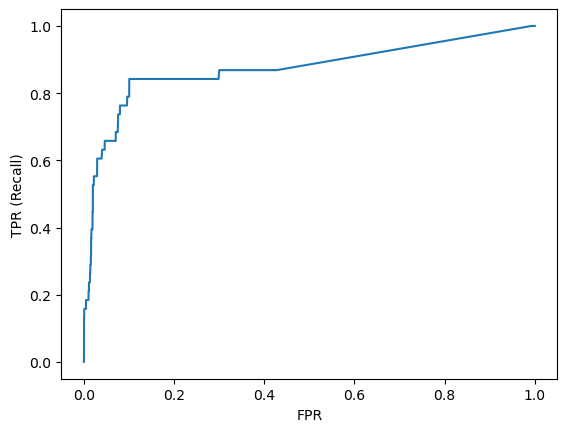

In [43]:
fpr, tpr, thresholds = roc_curve(y_test, best_lgbm_model.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (Recall)")
plt.show()

The graph above is known as a ROC Curve (Receiver Operating Characteristic Curve). More information regarding this metric and graph can be found [here](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc). As written in the article, the ROC Curve is a plot of the True Positive Rate, otherwise known as Recall, over the False Positive Rate across different classification thresholds. In other words, if we increase or reduce the probability our model predicts the target variable, `fire_tomorrow`, how does this model score on TPR and FPR. So, as we can see in the above graph, our model obtains a TPR of approximately $0.9$ at a FPR of $0.6$. This seems acceptable as our model is over predicting False Positives, meaning it predicts a fire tomorrow when there is no fire. 

<br>

## 13. Summary
<hr><br>

This project was a great way to practice the steps involved in typical machine learning analysis. We went from data extraction to data exploration, feature engineering, data preprocessing and tranformation, evaluating classifiers using model-based balancing, evaluating classifiers using sampling-based balancing, hyperparameter optimization, and evaluating our tuned `LGBMClassifier` on the test set. In the end, our model obtained a `roc_auc` score of $0.873$, meaning the probability it classifies a randomly picked example as `fire_tomorrow=1` over `fire_tomorrow=0` is $87$%. While this isn't exactly the performance we wanted, it is decent given the limited data and low number of positive examples ($0.13$%).